Ticket #122: https://noco.services.dataforgood.fr/dashboard/#/nc/pk1vq1pm8frc5lm/ms9uz8er4jpow7j?rowId=122
***
Nombre de prélèvements par famille de paramètres et par paramètre sur toute la France et par région, au fil des ans. 
Quantifications du nombre de prélèvements "exploitables" (i.e, comportant des mesures) et proportion de cas non conformes.

Focus sur les 5 familles suivantes:
* Métaux Lourds
* Sous produits de désinfection
* PCB
* Phtalates
* HAP

Remarques:
* hydrocarbures vs hydrocarbure... (contient benzène monocyclique mais aussi des HAP...) => Les deux catégories ont été regroupées dans cette analyse...
* Dans la première partie de cette étude, les données ont été analysées par région. Pour cela une table sur les codes régions a été introduite: https://www.data.gouv.fr/fr/datasets/departements-de-france/
* __/!\ Dans la seconde partie "livrables", deux colonnes ont été créées pour indique que le paramètre a été mesuré: _prct_quantif_ (présence d'une valeur tq 0.5, ou d'un seuil tq <0.1...) et _prct_quantif_precise_ (présence d'une valeur précise, et non pas d'un indicateur de seuil ou d'un texte) car la question n'était pas tout à fait claire pour moi.__
* /!\ __Limites valtraduite__: colonne utilisée car transforme toutes les mesures en valeurs numériques. Cependant des limitations importante sont observées comme vu précédemment, comme par exemple une valtraduite à 0 alors que la mesure indique un seuil assez élevé et supérieur au seuil indiqué dans la limite qualité, ce qui ne permet pas d'affirmer à 100% que la valeur respecte les taux...
__exemple: valeur mesurée "< 2" vs limite qualité "< 1" et valtraduite = 0__
Les détails sont visibles dans l'analyse, partie II/ 3/.
* Quantification param: présence de mentions "<SANS SEUIL" qui ne seront pas considérées faute de chiffre exact ou de valeur de seuil relevée...
* Comme discuté précédemment, il arrive très régulièrement que les seuils limites ne soient pas indiqués, pour ces cas les données sont donc incomplètes même si présence de quantification (d'où les colonnes de prct vides). 
* Les analyses vont ensuite comparer _valtraduite_ (malgré les limites discutées) aux _limites qualité_, les références qualités ne sont pas considérées ici. 


# I/ IMPORT PACKAGES, DONNÉES

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import re
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
pd.set_option("display.max_columns", None)  # show all cols
pd.set_option("display.max_colwidth", None)  # show full width of showing cols
pd.set_option(
    "display.expand_frame_repr", False
)  # print cols side by side as it's supposed to be

import duckdb
from pipelines.tasks._common import DUCKDB_FILE

con = duckdb.connect(database=DUCKDB_FILE, read_only=True)

In [59]:
# Configuration de l'extension SQL pour Jupyter...

%reload_ext sql
%sql duckdb:///../../database/data.duckdb


The 'toml' package isn't installed. To load settings from pyproject.toml or ~/.jupysql/config, install with: pip install toml

In [60]:
# Tables dispo dans la bdd
tables = con.execute("SHOW TABLES").fetchall()

print(tables)

[('edc_communes',), ('edc_prelevements',), ('edc_resultats',), ('mapping_categories',), ('stg_edc__communes',), ('stg_edc__prevelevements',), ('stg_edc__resultats',)]


In [62]:
%%sql
SELECT distinct LEFT(inseecommune, 2)
FROM edc_communes;

Running query in 'duckdb:///../../database/data.duckdb'

RuntimeError: (duckdb.duckdb.TransactionException) TransactionContext Error: Current transaction is aborted (please ROLLBACK)
[SQL: SELECT distinct LEFT(inseecommune, 2)
FROM edc_communes;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
If you need help solving this issue, send us a message: https://ploomber.io/community


In [53]:
%%sql
SELECT *
FROM edc_resultats
LIMIT 5

Running query in 'duckdb:///../../database/data.duckdb'

RuntimeError: (duckdb.duckdb.TransactionException) TransactionContext Error: Current transaction is aborted (please ROLLBACK)
[SQL: SELECT *
FROM edc_resultats
LIMIT 5]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
If you need help solving this issue, send us a message: https://ploomber.io/community


In [10]:
category = con.table("mapping_categories").to_df()

In [ ]:
prel = con.table("edc_prelevements").to_df()

In [6]:
category['libmajparametre'].nunique()

1588

In [63]:
category['categorie'].unique()

array(['pesticides', 'métabolite de pesticide', 'nitrite', 'pfas', 'cvm',
       'sous produit désinfection', 'perchlorate', 'métaux lourds',
       'hydrocarbures', 'hydrocarbure', 'pcb', 'dioxine et furane',
       'phtalate', 'phénol', 'médicament', 'paramètre organoleptique',
       'minéral', 'microbio', 'radioactivité', 'non classé'], dtype=object)

In [17]:
%%sql 
    SELECT res.*, cat.categorie
    FROM mapping_categories cat
    JOIN edc_resultats res on res.libmajparametre = cat.libmajparametre
    WHERE categorie IN ('métaux lourds', 'sous produit désinfection','pcb','phtalate', 'hydrocarbures', 'hydrocarbure')
    AND de_partition >= 2020;


Running query in 'duckdb:///../../database/data.duckdb'

cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,de_partition,de_ingestion_date,de_dataset_datetime,categorie
001,00100119085,AS,1369,ARSENIC,Arsenic,None,N,L,2,µg/L,133,<=10 µg/L,None,2.0,7440-38-2,00100125759,2020,2025-02-14,20230811-150005,métaux lourds
001,00100119085,BENZ,1114,BENZÈNE,Benzène,None,N,L,"<0,5",µg/L,133,<=1 µg/L,None,0.0,71-43-2,00100125759,2020,2025-02-14,20230811-150005,hydrocarbure
001,00100119085,BRATE,1751,BROMATES,Bromates,None,N,L,<3,µg/L,133,<=10 µg/L,None,0.0,15541-45-4,00100125759,2020,2025-02-14,20230811-150005,sous produit désinfection
001,00100119085,BRF,1122,BROMOFORME,Bromoforme,None,N,L,"2,40",µg/L,133,<=100 µg/L,None,2.4,75-25-2,00100125759,2020,2025-02-14,20230811-150005,sous produit désinfection
001,00100119085,CL,1337,CHLORURES,Chlorures,None,N,L,"25,2",mg/L,162,None,<=250 mg/L,25.2,None,00100125759,2020,2025-02-14,20230811-150005,sous produit désinfection
001,00100119085,CL2LIB,1398,CHLORE LIBRE,Chlore libre,None,N,T,"0,30",mg(Cl2)/L,165,None,None,0.3,None,None,2020,2025-02-14,20230811-150005,sous produit désinfection
001,00100119085,CL2TOT,1399,CHLORE TOTAL,Chlore total,None,N,T,"0,35",mg(Cl2)/L,165,None,None,0.35,None,None,2020,2025-02-14,20230811-150005,sous produit désinfection
001,00100119085,CLF,1135,CHLOROFORME,Chloroforme,None,N,L,"3,3",µg/L,133,<=100 µg/L,None,3.3,67-66-3,00100125759,2020,2025-02-14,20230811-150005,sous produit désinfection
001,00100119085,DBRMCL,1158,CHLORODIBROMOMÉTHANE,Chlorodibromométhane,None,N,L,"6,60",µg/L,133,<=100 µg/L,None,6.6,124-48-1,00100125759,2020,2025-02-14,20230811-150005,sous produit désinfection
001,00100119085,DCLMBR,1167,DICHLOROMONOBROMOMÉTHANE,Dichloromonobromométhane,None,N,L,"4,90",µg/L,133,<=100 µg/L,None,4.9,75-27-4,00100125759,2020,2025-02-14,20230811-150005,sous produit désinfection


In [19]:
query_5_families_res = """
    SELECT res.*, cat.categorie
    FROM mapping_categories cat
    JOIN edc_resultats res on res.libmajparametre = cat.libmajparametre
    WHERE categorie IN ('métaux lourds', 'sous produit désinfection','pcb','phtalate', 'hydrocarbures', 'hydrocarbure')
    AND de_partition >= 2020;
"""

In [22]:
res_test = con.execute(query_5_families_res).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [23]:
res_test

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,...,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,de_partition,de_ingestion_date,de_dataset_datetime,categorie
0,001,00100119085,AS,1369,ARSENIC,Arsenic,None,N,L,2,...,133,<=10 µg/L,None,2.0,7440-38-2,00100125759,2020,2025-02-14,20230811-150005,métaux lourds
1,001,00100119085,BENZ,1114,BENZÈNE,Benzène,None,N,L,"<0,5",...,133,<=1 µg/L,None,0.0,71-43-2,00100125759,2020,2025-02-14,20230811-150005,hydrocarbure
2,001,00100119085,BRATE,1751,BROMATES,Bromates,None,N,L,<3,...,133,<=10 µg/L,None,0.0,15541-45-4,00100125759,2020,2025-02-14,20230811-150005,sous produit désinfection
3,001,00100119085,BRF,1122,BROMOFORME,Bromoforme,None,N,L,"2,40",...,133,<=100 µg/L,None,2.4,75-25-2,00100125759,2020,2025-02-14,20230811-150005,sous produit désinfection
4,001,00100119085,CL,1337,CHLORURES,Chlorures,None,N,L,"25,2",...,162,None,<=250 mg/L,25.2,None,00100125759,2020,2025-02-14,20230811-150005,sous produit désinfection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7412439,077,07700249497,12DCLE,1161,"DICHLOROÉTHANE-1,2","Dichloroéthane-1,2",None,N,L,"<0,10",...,133,<=3 µg/L,None,0.0,107-06-2,07700249273,2024,2025-02-14,20250203-075802,hydrocarbure
7412440,077,07700249497,HCB,1199,HEXACHLOROBENZÈNE,Hexachlorobenzène,None,N,L,"<0,005",...,133,"<=0,1 µg/L",None,0.0,118-74-1,07700249273,2024,2025-02-14,20250203-075802,hydrocarbure
7412441,077,07700249497,PCB138,1244,PCB 138,PCB 138,None,N,L,"<0,010",...,133,None,None,0.0,35065-28-2,07700249273,2024,2025-02-14,20250203-075802,pcb
7412442,077,07700249497,TCLEY,1286,TRICHLOROÉTHYLÈNE,Trichloroéthylène,None,N,L,"<0,10",...,133,<=10 µg/L,None,0.0,79-01-6,07700249273,2024,2025-02-14,20250203-075802,hydrocarbure


# II/ ANALYSE GLOBALE, PAR FAMILLE DE PARAMÈTRE

In [33]:
res_test['categorie'] = res_test['categorie'].replace('hydrocarbure', 'hydrocarbures')

In [543]:
# 1/ GLOBAL - Combien de fois les paramètres ont été recherchés par an dans la France entière ?

res_test.groupby(['categorie','de_partition']).size()

categorie                  de_partition
hydrocarbures              2020            465484
                           2021            368679
                           2022            371530
                           2023            355146
                           2024            345889
métaux lourds              2020            145309
                           2021            148116
                           2022            148179
                           2023            145654
                           2024            142102
pcb                        2020            122095
                           2021            110961
                           2022             95883
                           2023             79675
                           2024             74167
phtalate                   2020              1169
                           2021                92
                           2022                89
                           2023                95
          

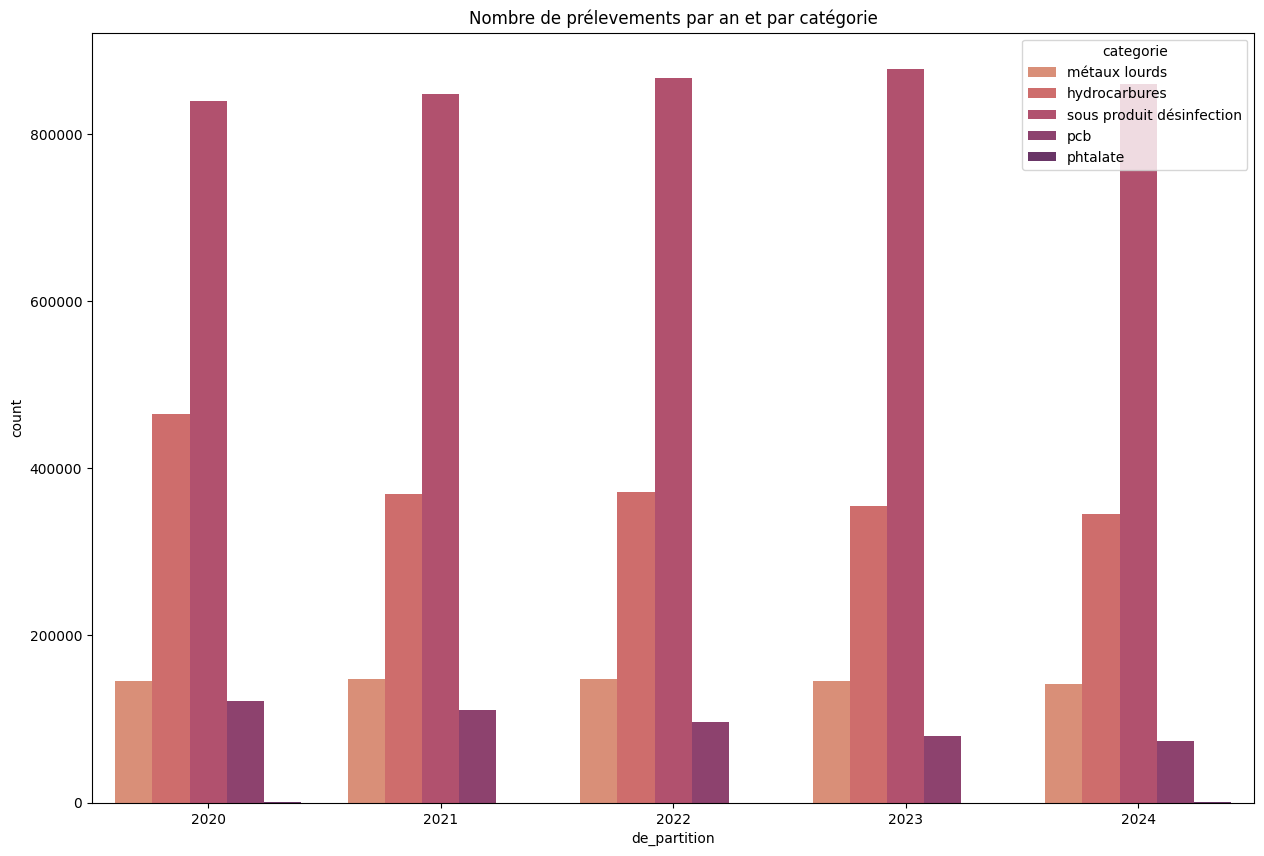

In [39]:
plt.figure(figsize = [15, 10])

sns.countplot(res_test, x="de_partition", hue="categorie", palette = "flare", )

plt.title('Nombre de prélevements par an et par catégorie')

plt.show()

In [66]:
# 2 GLOBAL - Est-ce qu’il y a eu des recherches dans toutes les régions? 
# Sinon, dans quelles régions ils ont été recherchés? (pas besoin de descendre à la commune à ce stade).


res_test['cddept'].nunique() #ok tous les départements 

101

In [70]:
res_test['cddept'].unique()

array(['001', '004', '005', '002', '007', '006', '008', '003', '009',
       '010', '011', '013', '012', '014', '015', '016', '017', '018',
       '021', '019', '022', '024', '023', '025', '026', '027', '029',
       '028', '02B', '030', '02A', '031', '032', '033', '034', '035',
       '036', '037', '038', '039', '041', '040', '042', '044', '043',
       '045', '046', '047', '049', '048', '050', '051', '052', '053',
       '054', '056', '057', '058', '055', '059', '060', '061', '062',
       '063', '065', '064', '066', '067', '068', '069', '070', '072',
       '071', '073', '074', '075', '076', '077', '078', '080', '081',
       '082', '079', '083', '084', '086', '088', '089', '085', '087',
       '090', '091', '092', '093', '095', '971', '974', '094', '972',
       '976', '973'], dtype=object)

In [78]:
#TESTS 
#res_test['cddept'][0][:1]

for dep in res_test['cddept']:
    if dep[:1] == '0':
        print(dep[1:])
        break

01


In [82]:
# Standardiser les num départements dans une colonne 'dep' pour pouvoir la lier à notre table des régions
res_test['code_departement'] = res_test['cddept'].apply(lambda x: x[1:] if x[:1] == '0' else x)

In [83]:
res_test['code_departement'].unique()

array(['01', '04', '05', '02', '07', '06', '08', '03', '09', '10', '11',
       '13', '12', '14', '15', '16', '17', '18', '21', '19', '22', '24',
       '23', '25', '26', '27', '29', '28', '2B', '30', '2A', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '41', '40', '42', '44',
       '43', '45', '46', '47', '49', '48', '50', '51', '52', '53', '54',
       '56', '57', '58', '55', '59', '60', '61', '62', '63', '65', '64',
       '66', '67', '68', '69', '70', '72', '71', '73', '74', '75', '76',
       '77', '78', '80', '81', '82', '79', '83', '84', '86', '88', '89',
       '85', '87', '90', '91', '92', '93', '95', '971', '974', '94',
       '972', '976', '973'], dtype=object)

In [68]:
# On charge une table contenant les correspondances régions/deépartements provenant de data gouv: 
# https://www.data.gouv.fr/fr/datasets/departements-de-france/

region = pd.read_csv('/Users/lise/Desktop/repo_d4g/forked/13_pollution_eau/database/departements-france.csv')

In [89]:
res_test['code_departement']

0          01
1          01
2          01
3          01
4          01
           ..
7412439    77
7412440    77
7412441    77
7412442    77
7412443    77
Name: code_departement, Length: 7412444, dtype: object

In [91]:
region[['nom_departement', 'nom_region']]

,nom_departement,nom_region
0,Ain,Auvergne-Rhône-Alpes
1,Aisne,Hauts-de-France
2,Allier,Auvergne-Rhône-Alpes
3,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur
4,Hautes-Alpes,Provence-Alpes-Côte d'Azur
...,...,...
96,Guadeloupe,Guadeloupe
97,Martinique,Martinique
98,Guyane,Guyane
99,La Réunion,La Réunion


In [97]:
region['code_region'].nunique() #18 régions 

18

In [93]:
res_test_region = res_test.merge(region[['code_departement','nom_departement', 'nom_region']], on  = 'code_departement')

In [98]:
res_test_region['nom_region'].nunique() #on a bien toutes les régions 

18

/var/folders/sb/kbw95mq10b76gs1b7tjqtbgm0000gn/T/ipykernel_56108/1624911362.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y = 'nom_region',


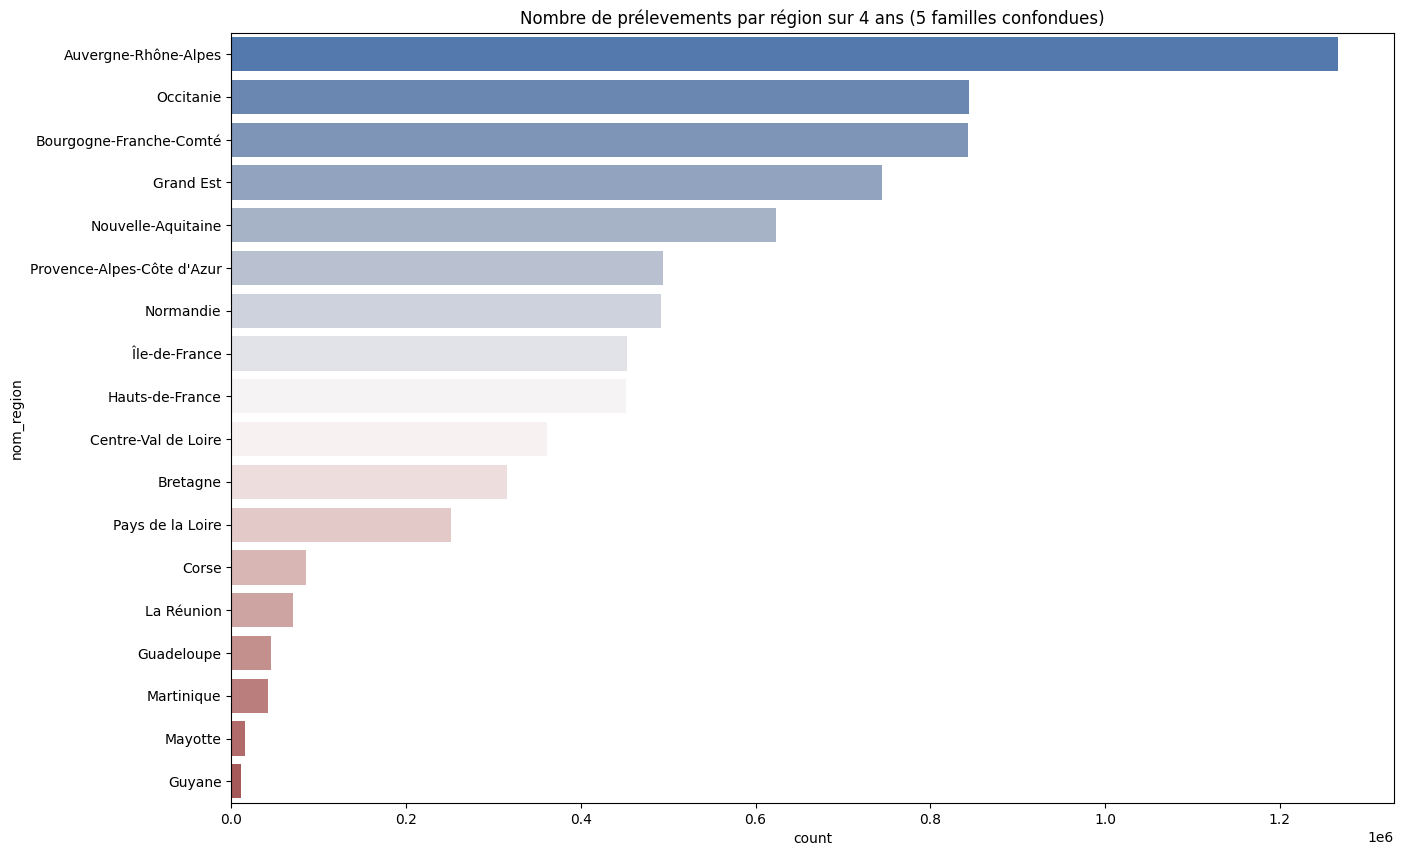

In [106]:
# nombre de résultats par région sur 4 ans
plt.figure(figsize = [15, 10])

sns.countplot(y = 'nom_region',
              data = res_test_region,
              order = res_test_region['nom_region'].value_counts().index,
             palette = 'vlag')

plt.title('Nombre de prélevements par région sur 4 ans (5 familles confondues)')

plt.show()

In [107]:
res_test_region['nom_region'].value_counts()

nom_region
Auvergne-Rhône-Alpes          1267128
Occitanie                      844184
Bourgogne-Franche-Comté        843511
Grand Est                      744408
Nouvelle-Aquitaine             623355
Provence-Alpes-Côte d'Azur     494306
Normandie                      491971
Île-de-France                  453099
Hauts-de-France                452181
Centre-Val de Loire            361543
Bretagne                       315641
Pays de la Loire               250919
Corse                           85515
La Réunion                      70918
Guadeloupe                      45996
Martinique                      41502
Mayotte                         15438
Guyane                          10829
Name: count, dtype: int64

/var/folders/sb/kbw95mq10b76gs1b7tjqtbgm0000gn/T/ipykernel_56108/2206427947.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y = 'nom_region',


Nombre de prélevements par région sur l'année 2024 (5 familles confondues)


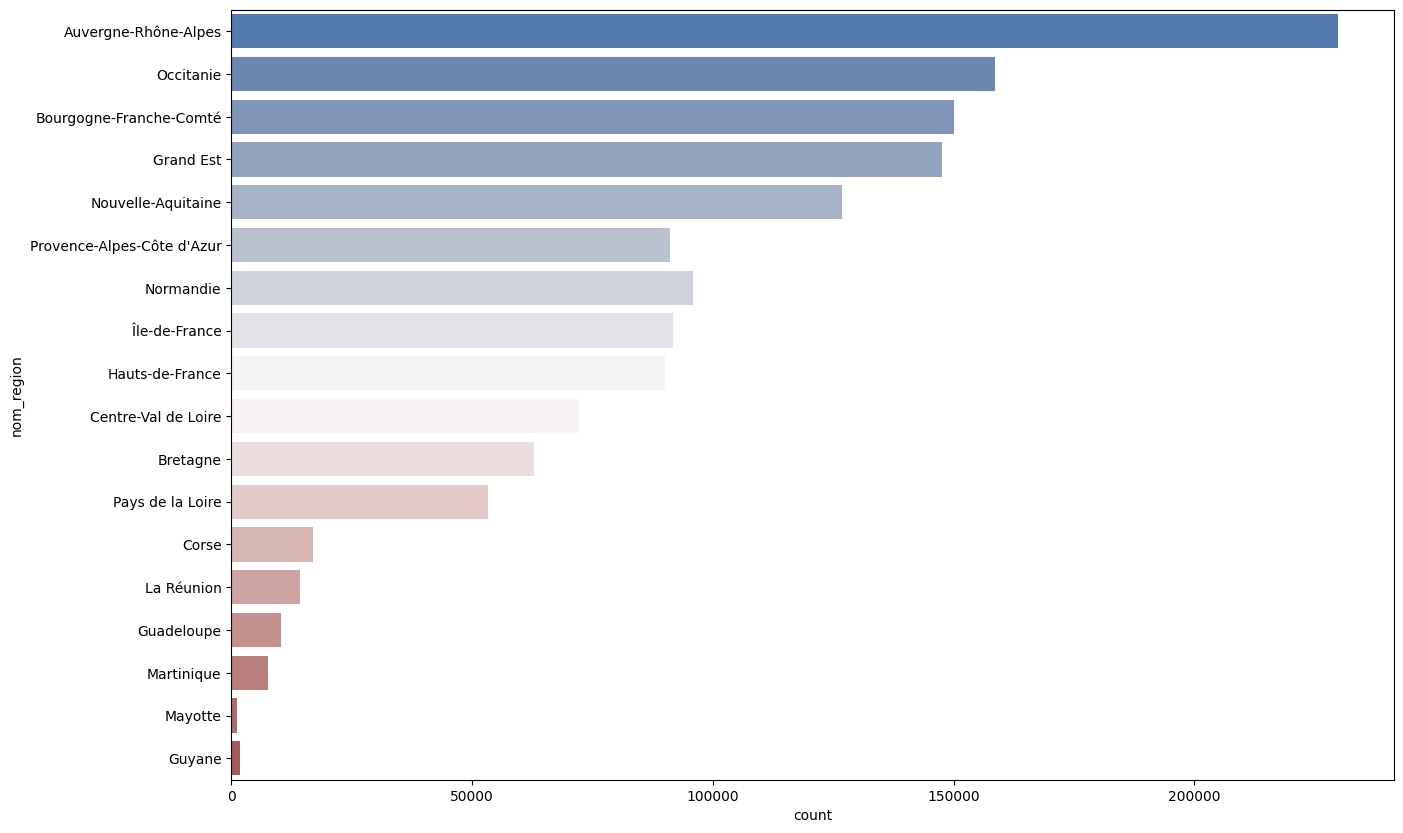

In [115]:
# nombre de résultats par région sur 4 ans

year = 2024 #indiquer l'année à étudier

plt.figure(figsize = [15, 10])

sns.countplot(y = 'nom_region',
              data = res_test_region[res_test_region['de_partition'] == year],
              order = res_test_region['nom_region'].value_counts().index,
             palette = 'vlag')

print("Nombre de prélevements par région sur l'année", year, "(5 familles confondues)")

plt.show()


In [120]:
res_test_region.groupby(['nom_region', 'categorie']).value_counts()

nom_region                  categorie                
Auvergne-Rhône-Alpes        hydrocarbures                427202
                            métaux lourds                119114
                            pcb                           26458
                            phtalate                        124
                            sous produit désinfection    694230
                                                          ...  
Provence-Alpes-Côte d'Azur  sous produit désinfection    301226
Île-de-France               hydrocarbures                 64813
                            métaux lourds                 30488
                            pcb                           44393
                            sous produit désinfection    313405
Length: 73, dtype: int64

In [147]:
print("Catégories les plus vs les moins recherchées par région, parmis les 5 familles d'intérêt", "\n")

for region in res_test_region['nom_region'].unique():
    print(region,":")
    print("+", 
         res_test_region[res_test_region['nom_region'] == region]['categorie'].value_counts().index[0],
         ':', 
         res_test_region[res_test_region['nom_region'] == region]['categorie'].value_counts()[0])         
    print("-", 
         res_test_region[res_test_region['nom_region'] == region]['categorie'].value_counts().index[-1],
         ':', 
         res_test_region[res_test_region['nom_region'] == region]['categorie'].value_counts()[-1], "\n")



Catégories les plus vs les moins recherchées par région, parmis les 5 familles d'intérêt 

Auvergne-Rhône-Alpes :
+ sous produit désinfection : 694230
- phtalate : 124 

Provence-Alpes-Côte d'Azur :
+ sous produit désinfection : 301226
- pcb : 46155 

Hauts-de-France :
+ sous produit désinfection : 299418
- pcb : 96 

Grand Est :
+ sous produit désinfection : 502866
- phtalate : 12 

Occitanie :
+ sous produit désinfection : 590642
- phtalate : 27 

Normandie :
+ hydrocarbures : 213858
- phtalate : 19 

Nouvelle-Aquitaine :
+ sous produit désinfection : 365157
- phtalate : 2 

Centre-Val de Loire :
+ sous produit désinfection : 211244
- pcb : 916 

Bourgogne-Franche-Comté :
+ pcb : 308597
- phtalate : 1363 

Bretagne :
+ sous produit désinfection : 227977
- métaux lourds : 25480 

Corse :
+ sous produit désinfection : 57013
- pcb : 6280 

Pays de la Loire :
+ sous produit désinfection : 169902
- phtalate : 3 

Île-de-France :
+ sous produit désinfection : 313405
- métaux lourds : 30488

Evolution du nb de prélèvements par an pour la région Auvergne-Rhône-Alpes


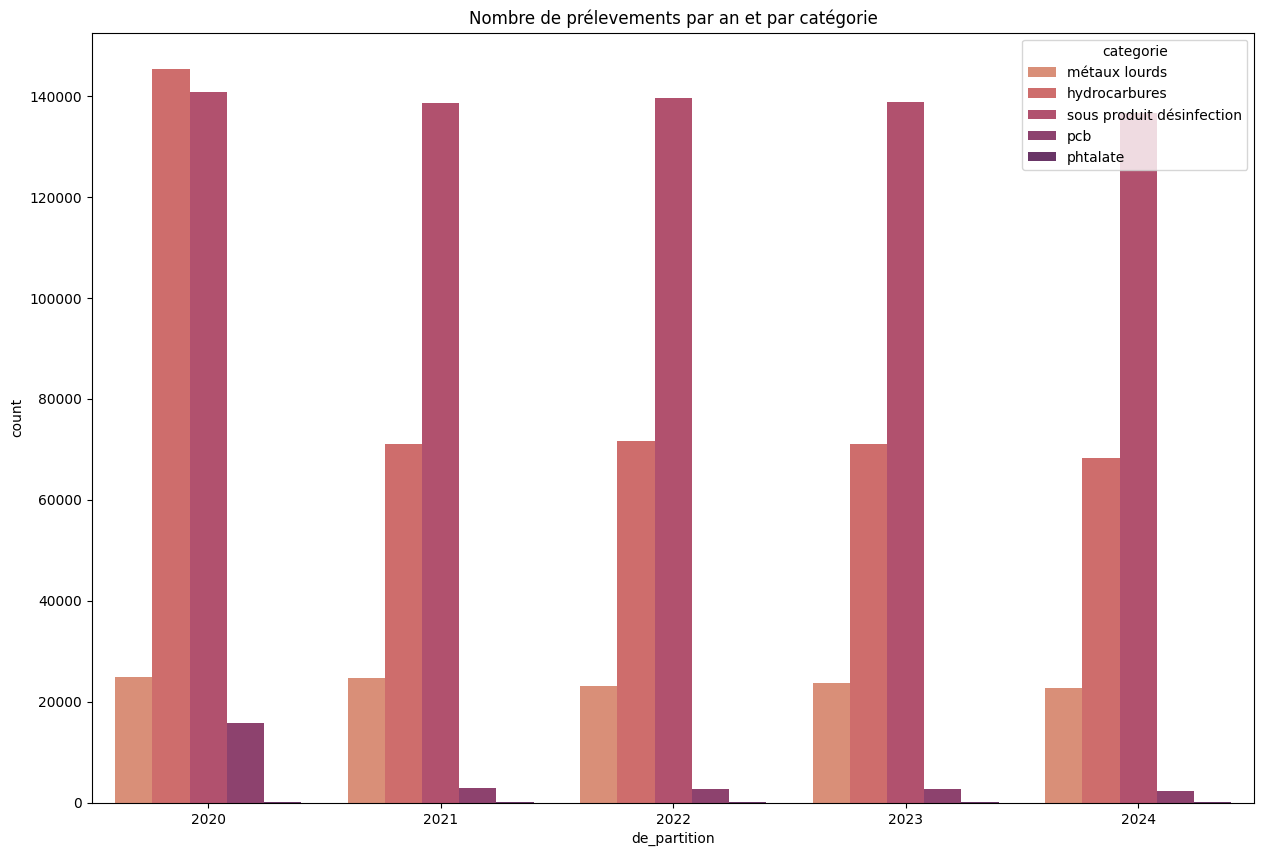

Evolution du nb de prélèvements par an pour la région Provence-Alpes-Côte d'Azur


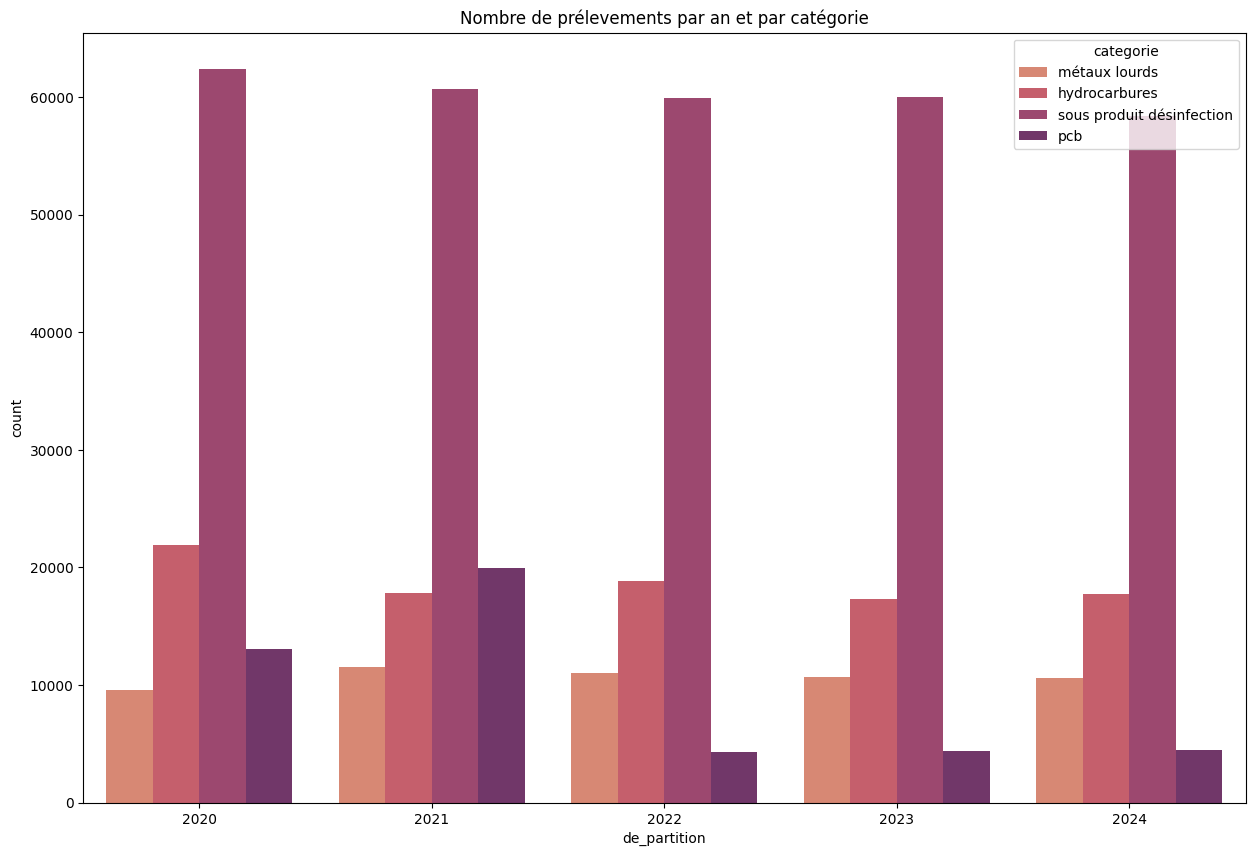

Evolution du nb de prélèvements par an pour la région Hauts-de-France


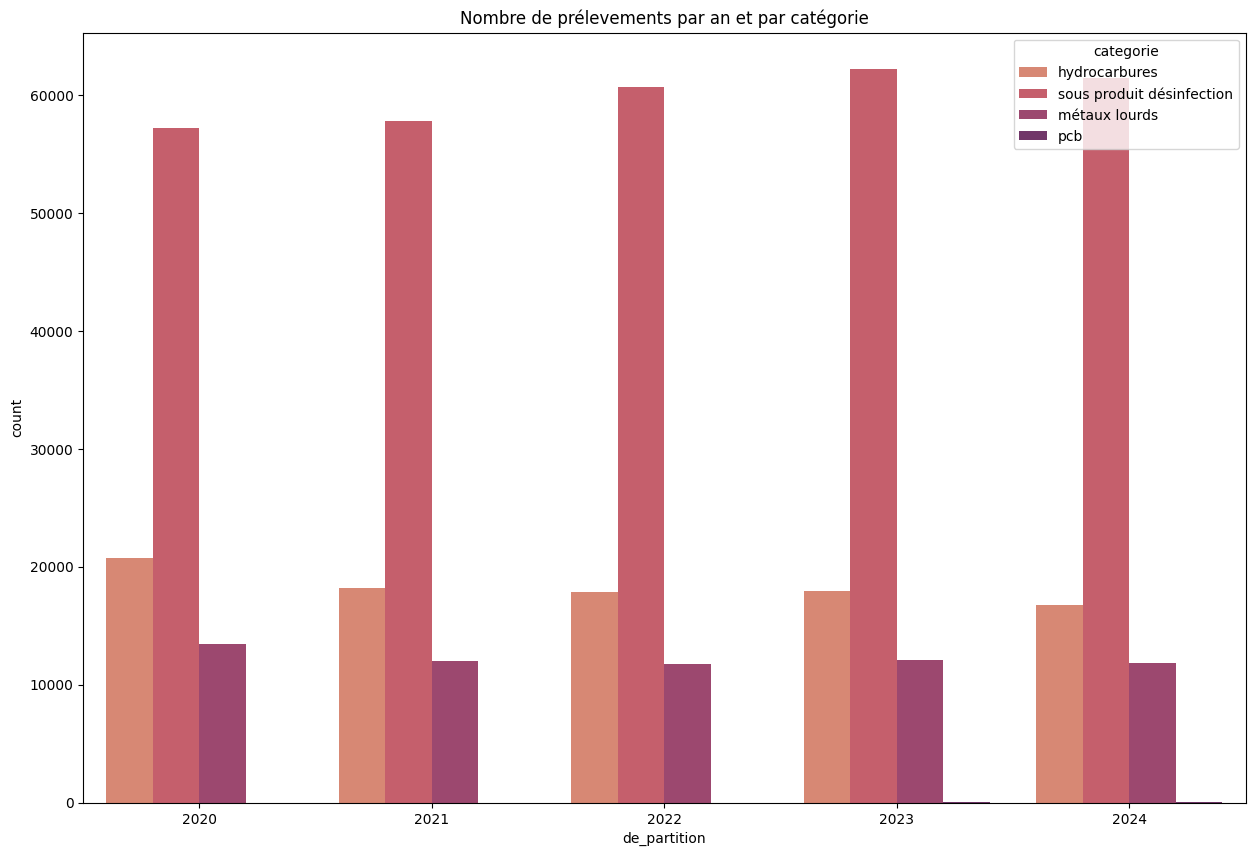

Evolution du nb de prélèvements par an pour la région Grand Est


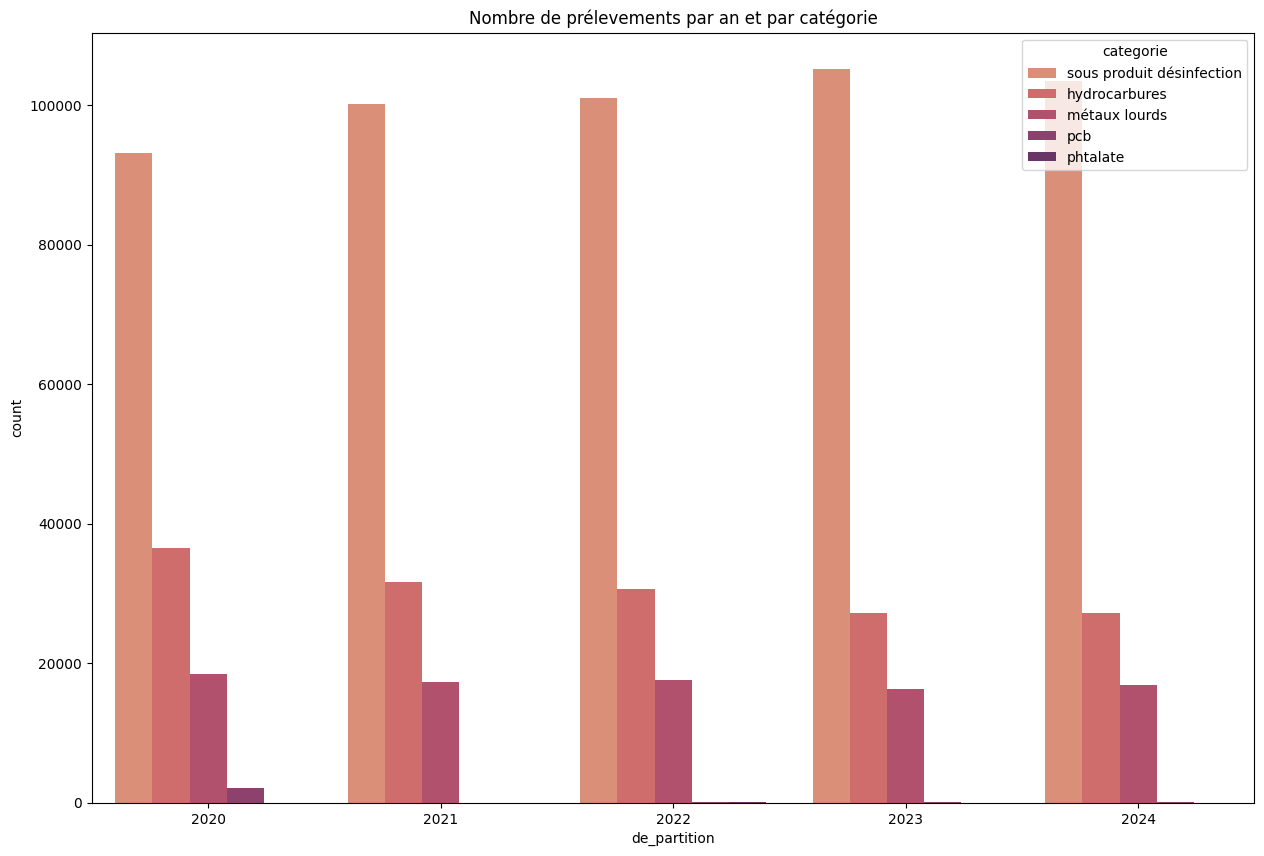

Evolution du nb de prélèvements par an pour la région Occitanie


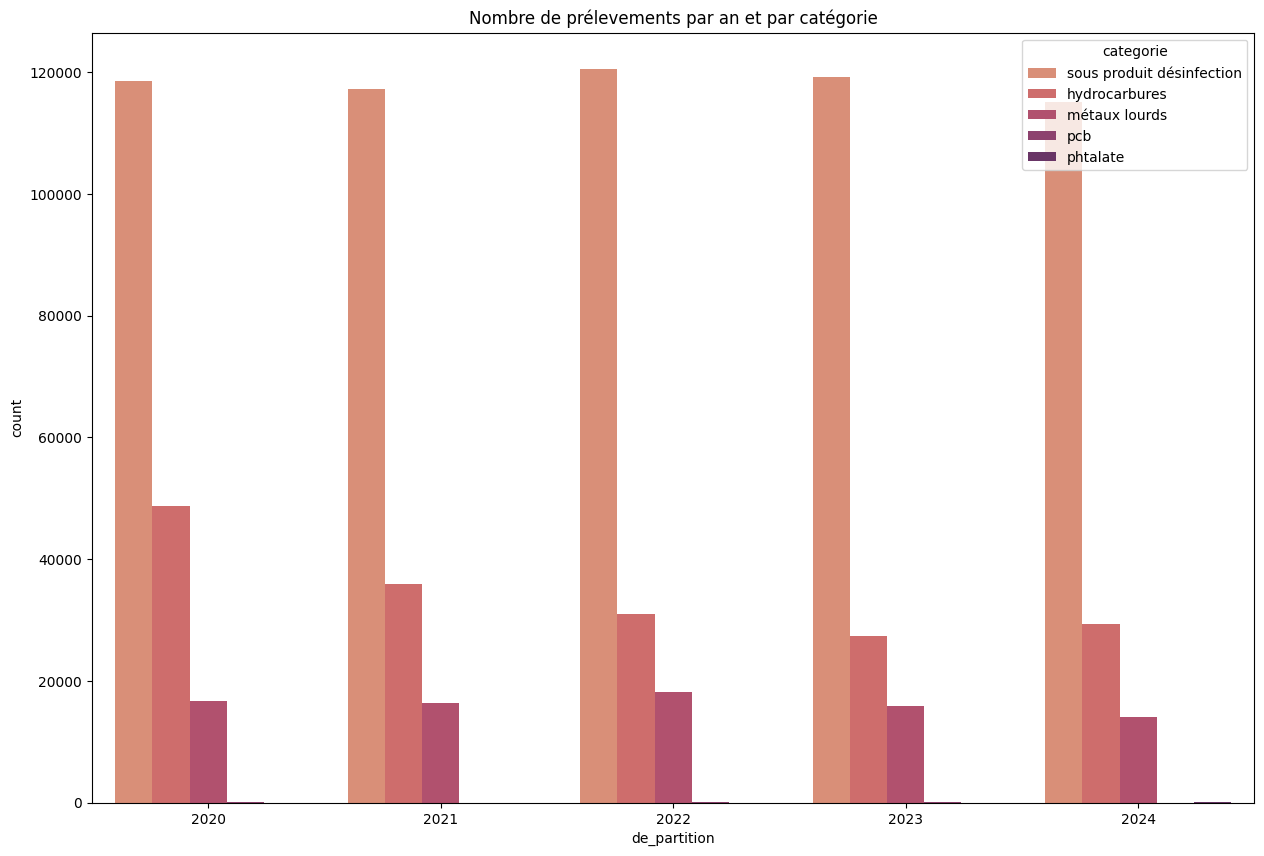

Evolution du nb de prélèvements par an pour la région Normandie


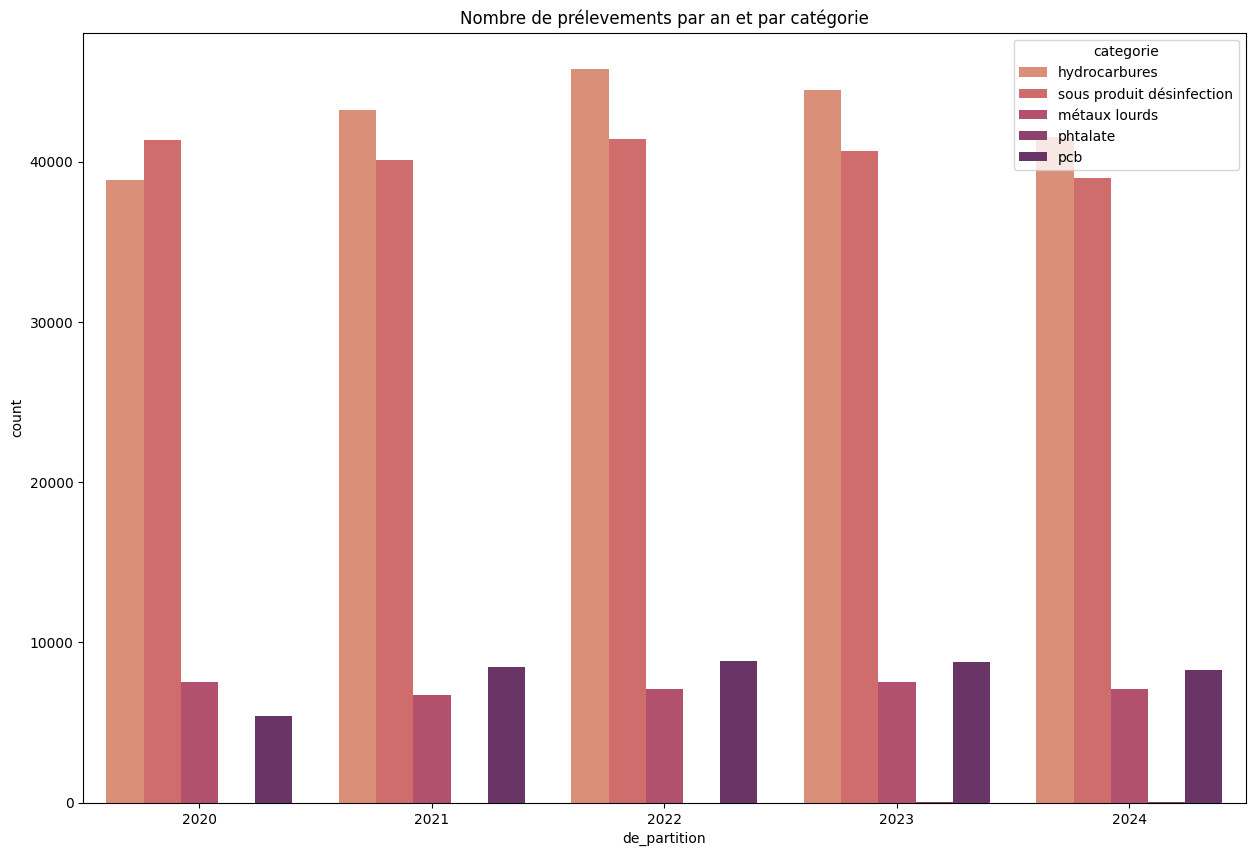

Evolution du nb de prélèvements par an pour la région Nouvelle-Aquitaine


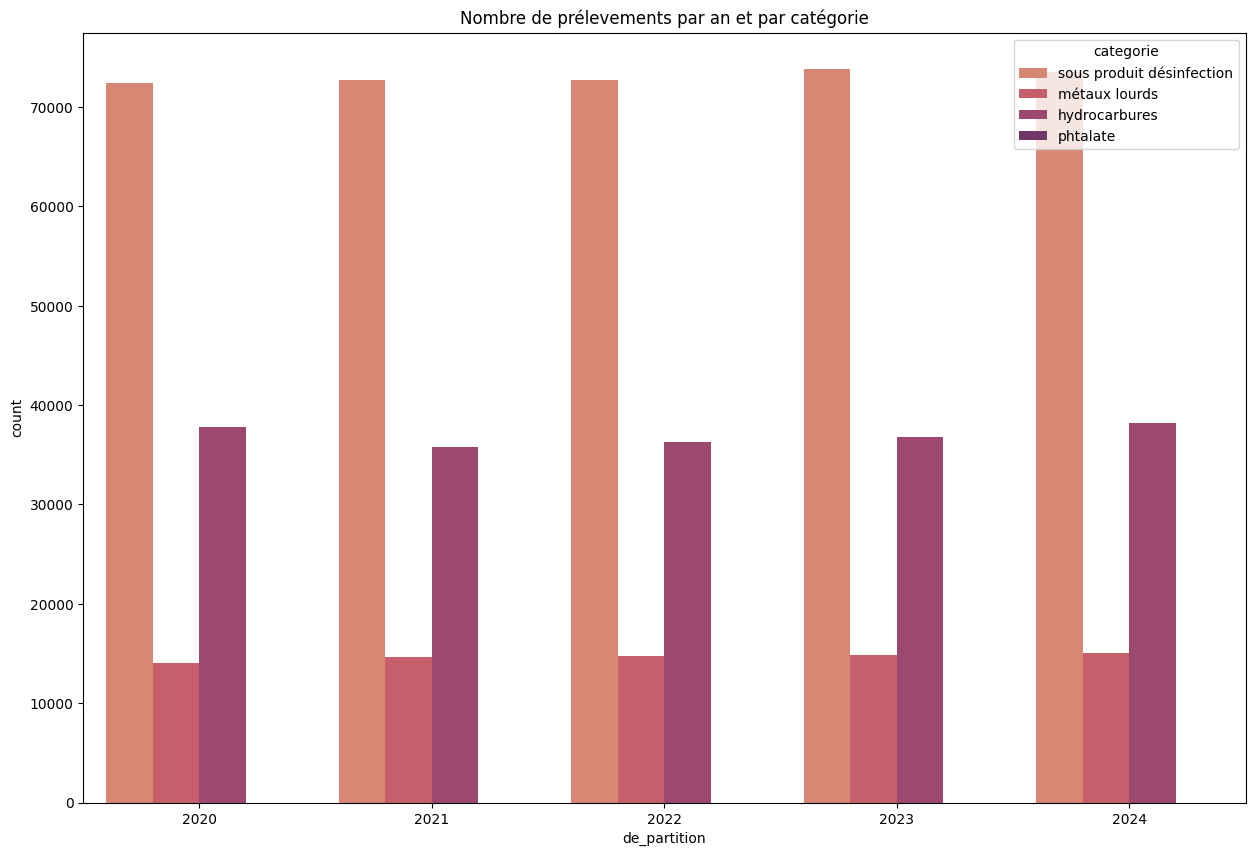

Evolution du nb de prélèvements par an pour la région Centre-Val de Loire


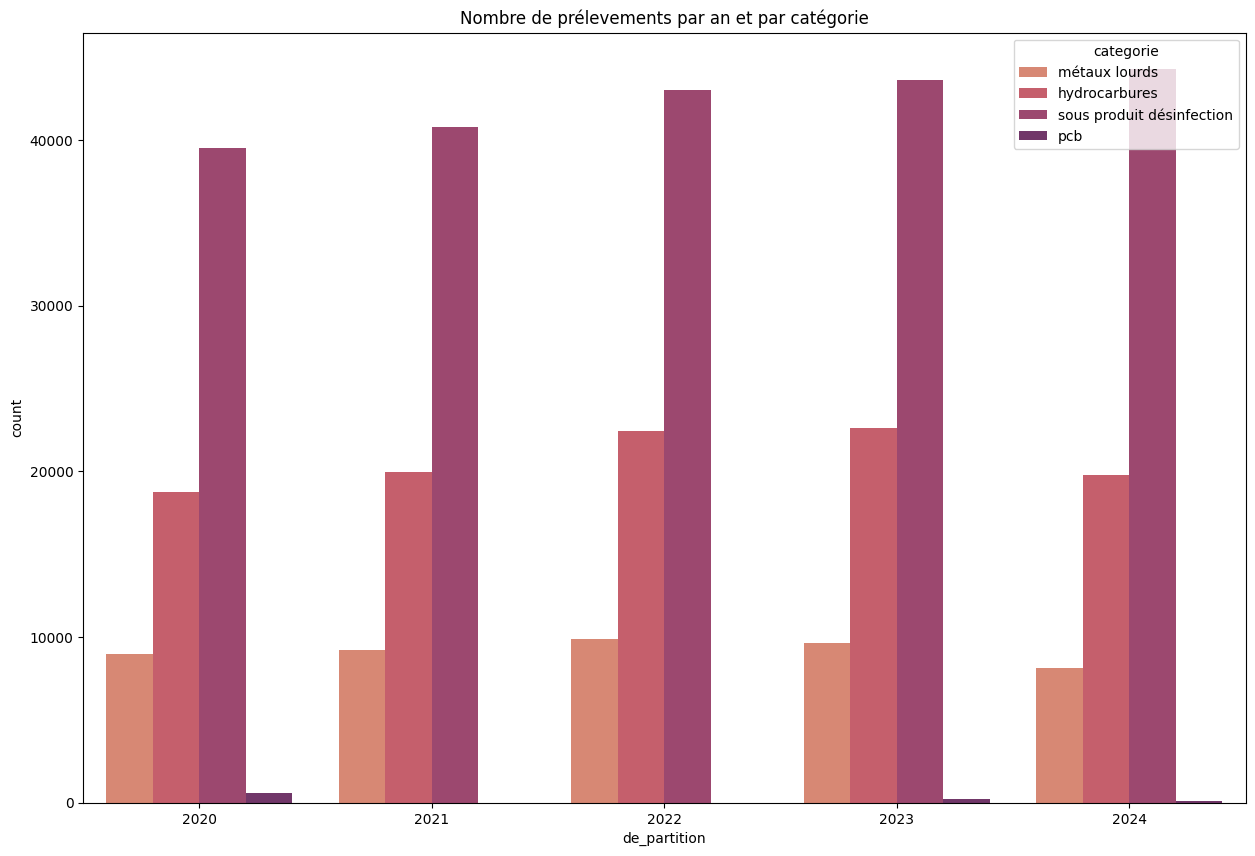

Evolution du nb de prélèvements par an pour la région Bourgogne-Franche-Comté


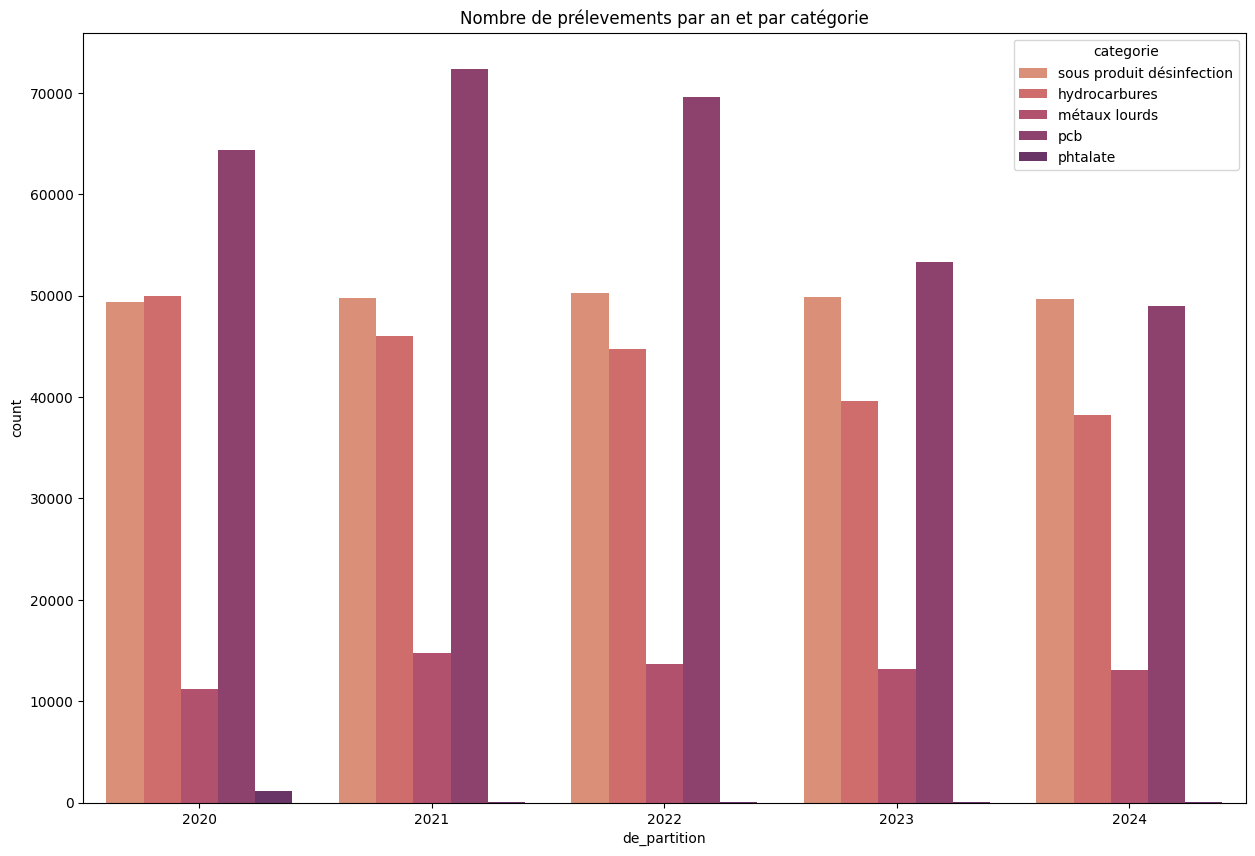

Evolution du nb de prélèvements par an pour la région Bretagne


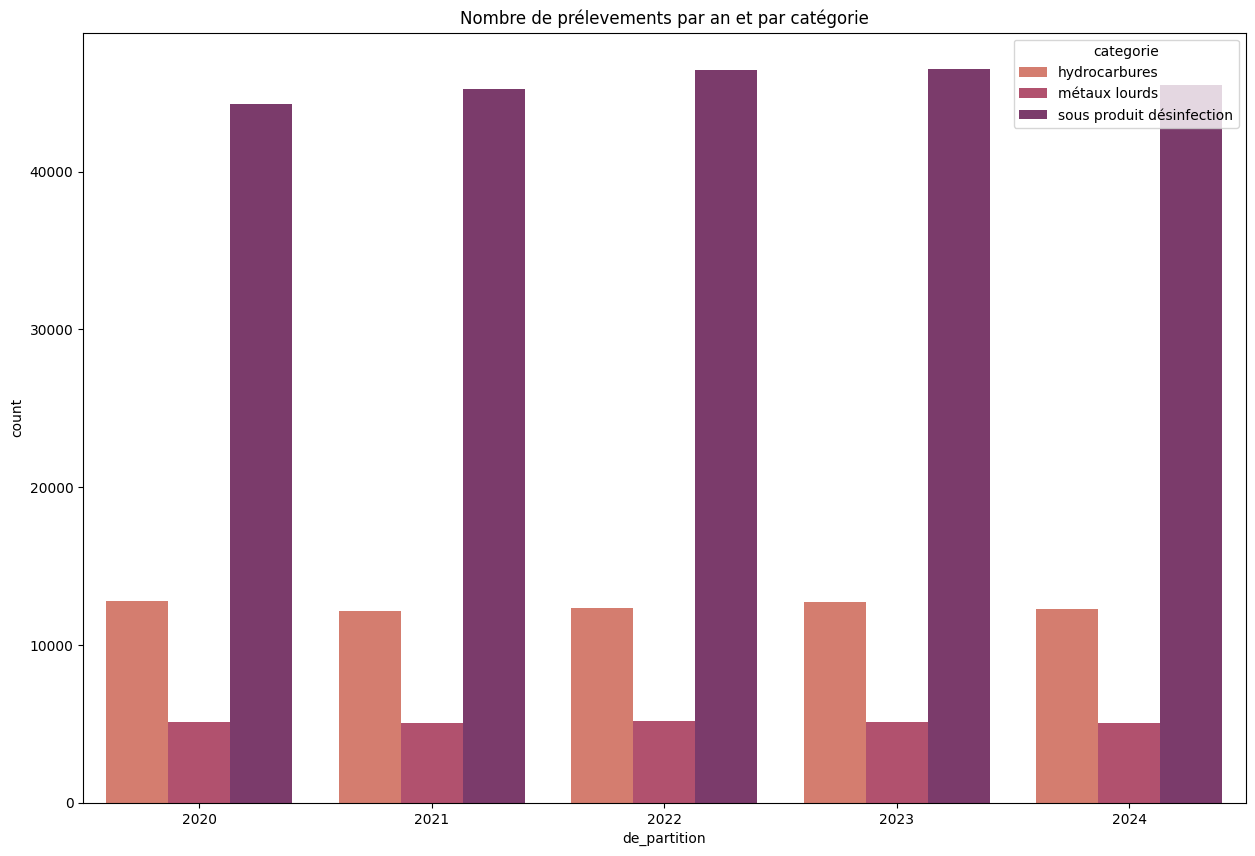

Evolution du nb de prélèvements par an pour la région Corse


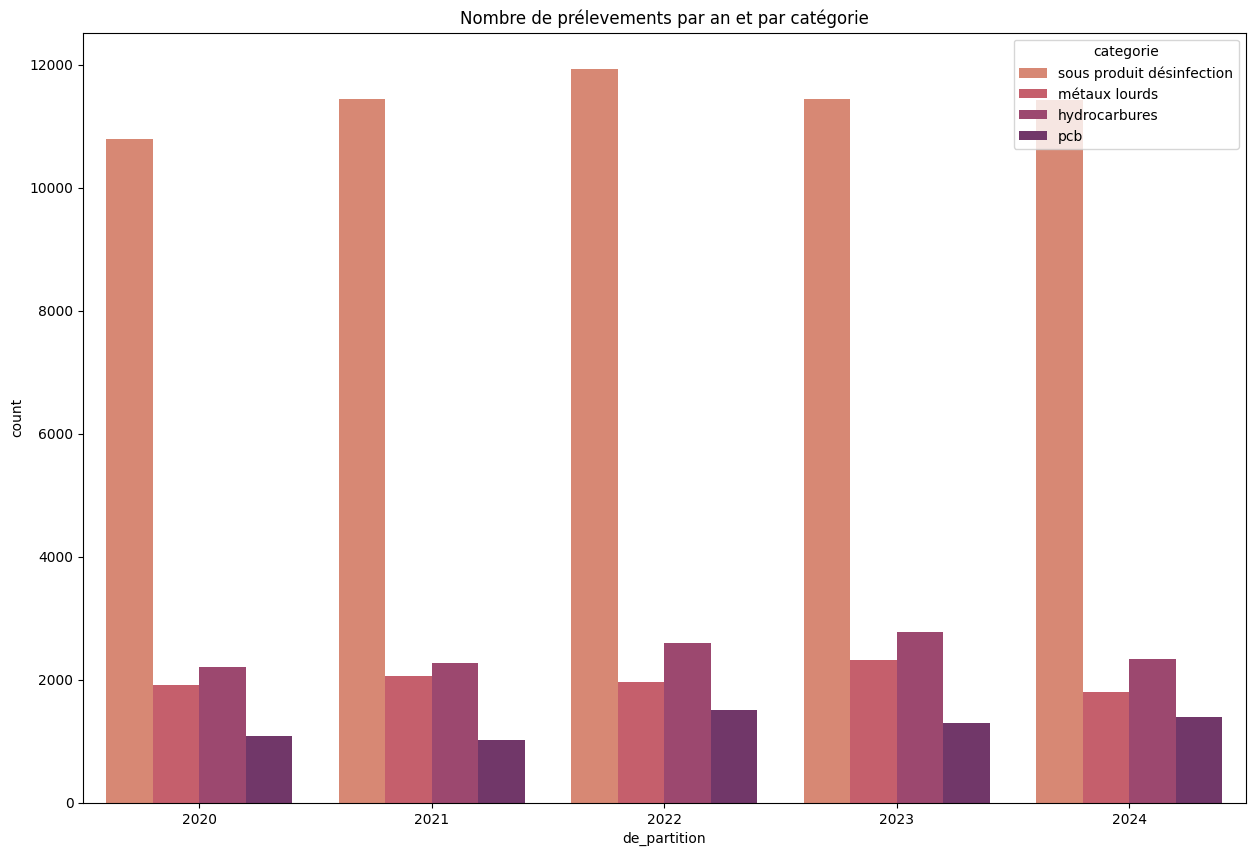

Evolution du nb de prélèvements par an pour la région Pays de la Loire


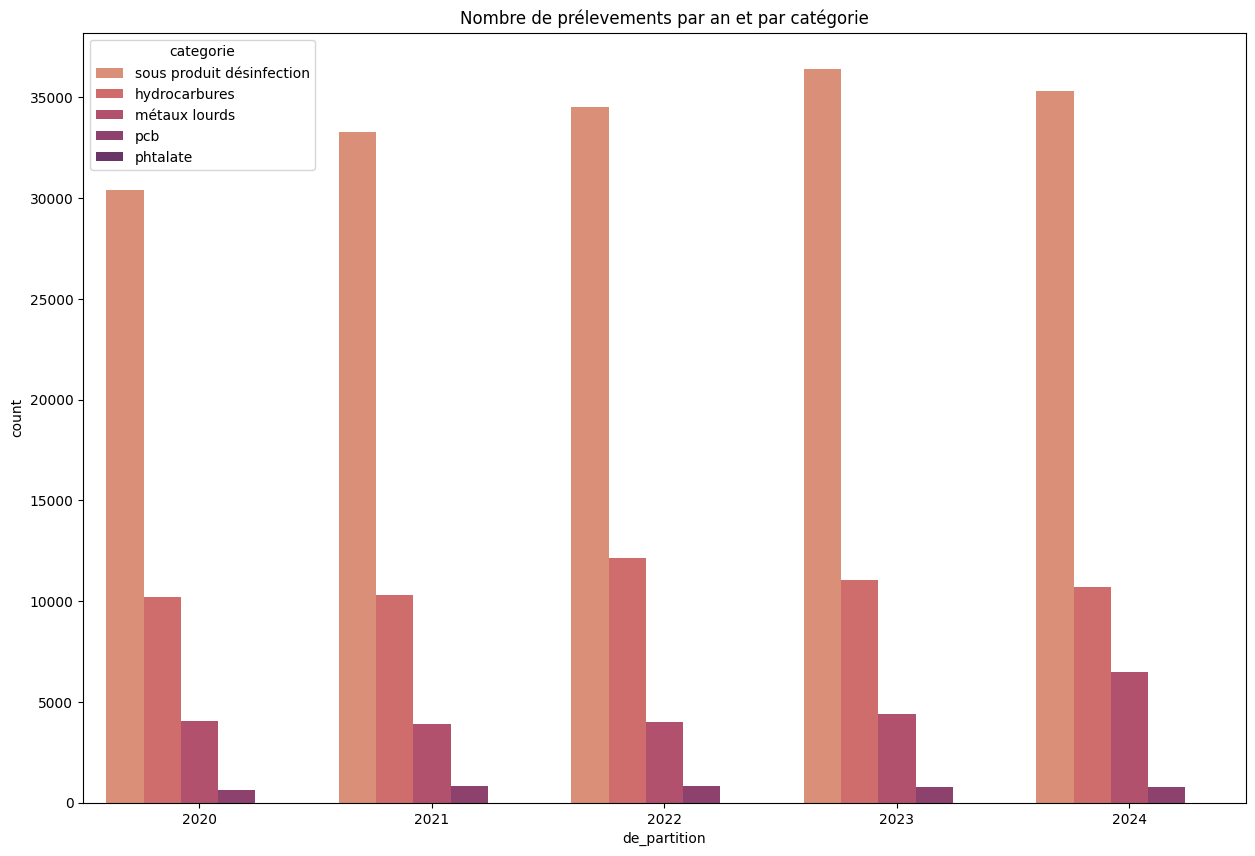

Evolution du nb de prélèvements par an pour la région Île-de-France


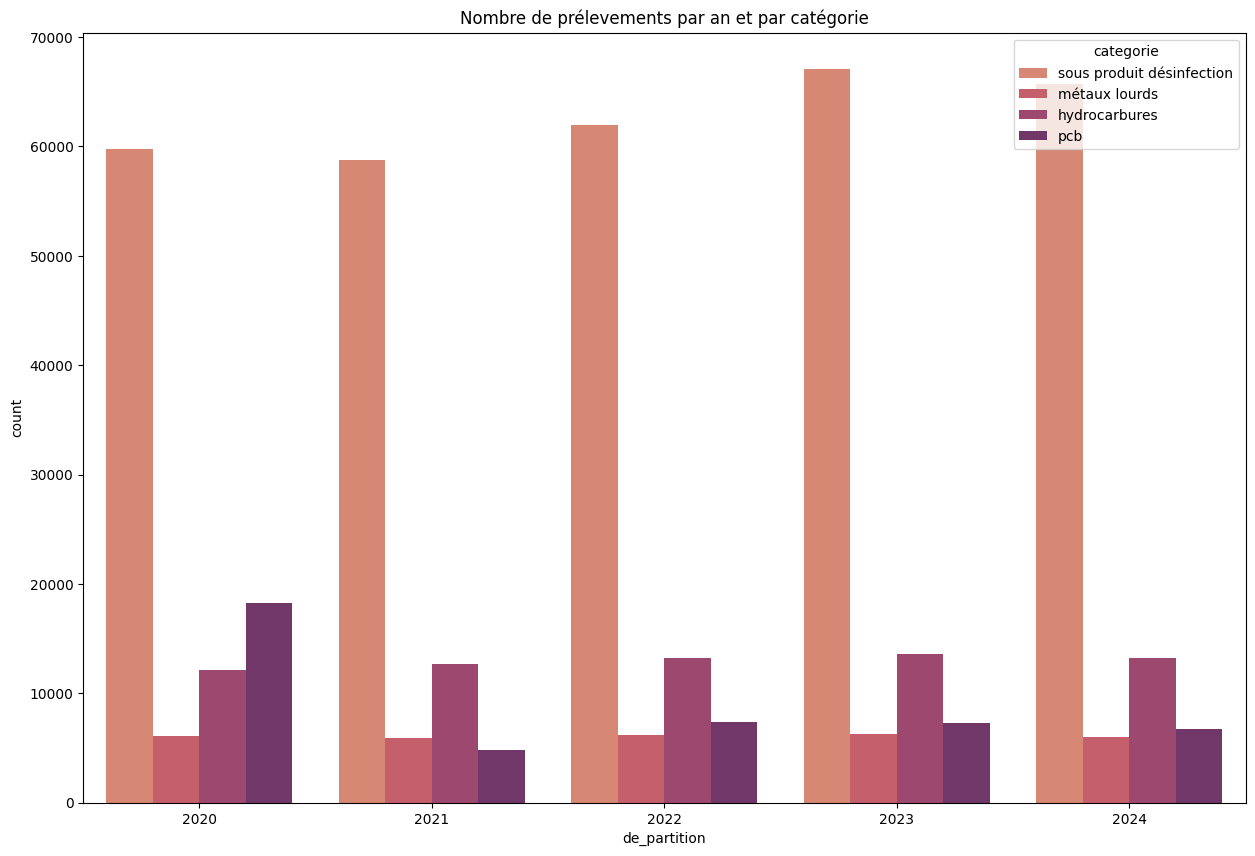

Evolution du nb de prélèvements par an pour la région Guadeloupe


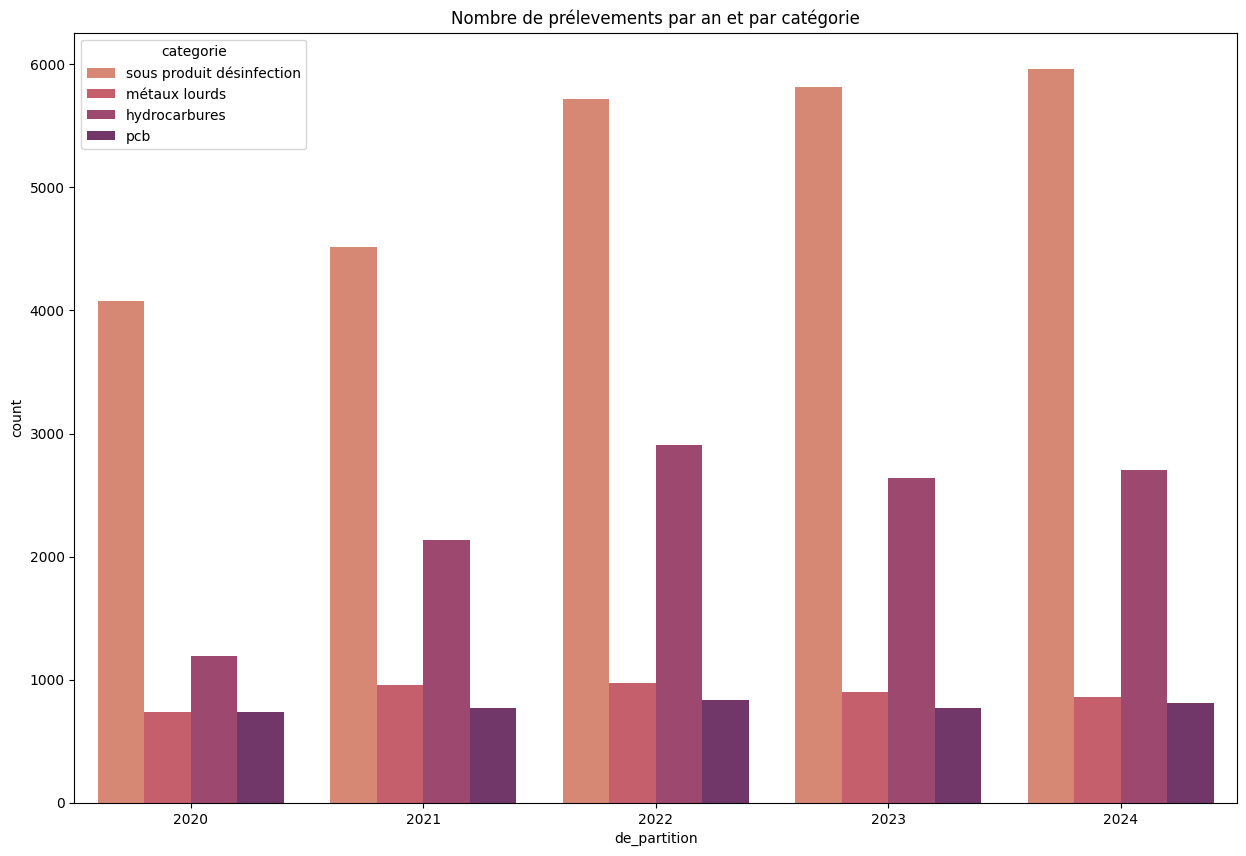

Evolution du nb de prélèvements par an pour la région La Réunion


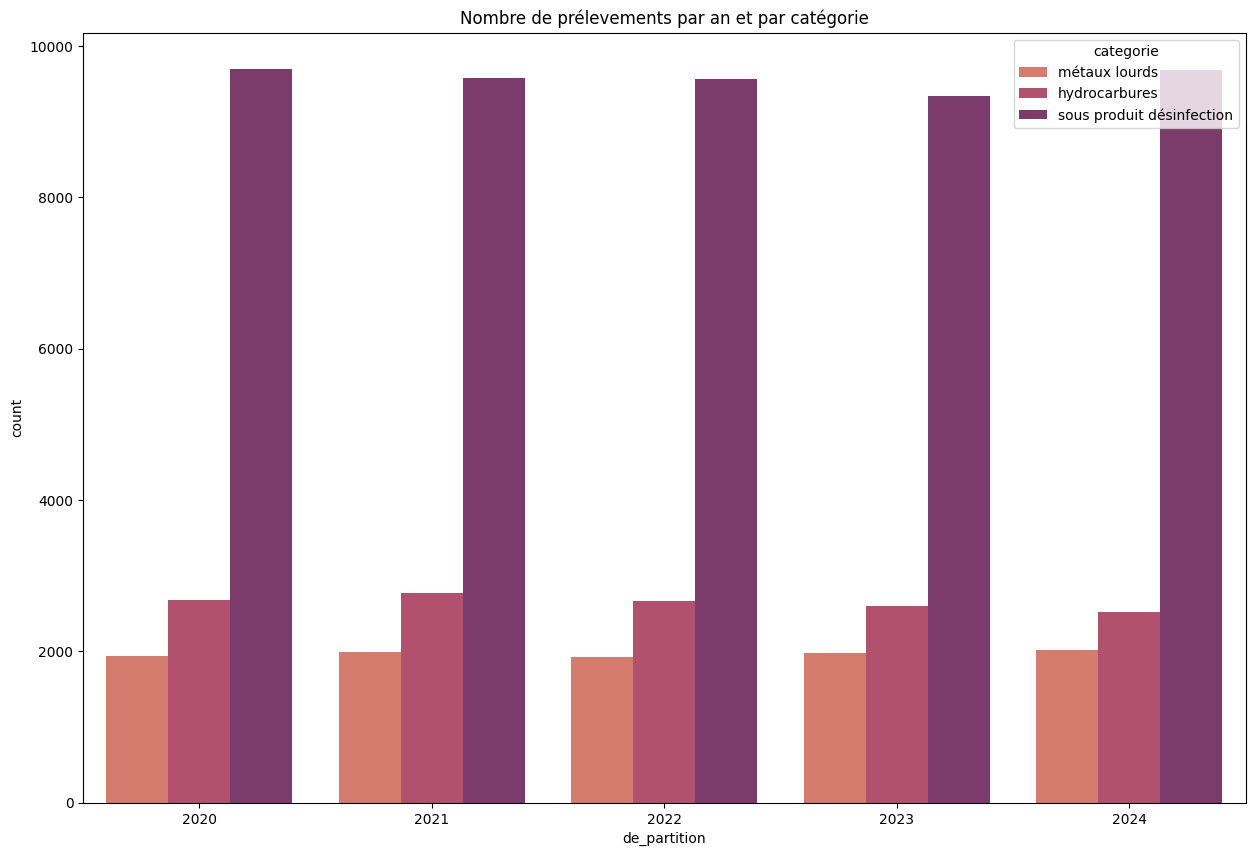

Evolution du nb de prélèvements par an pour la région Martinique


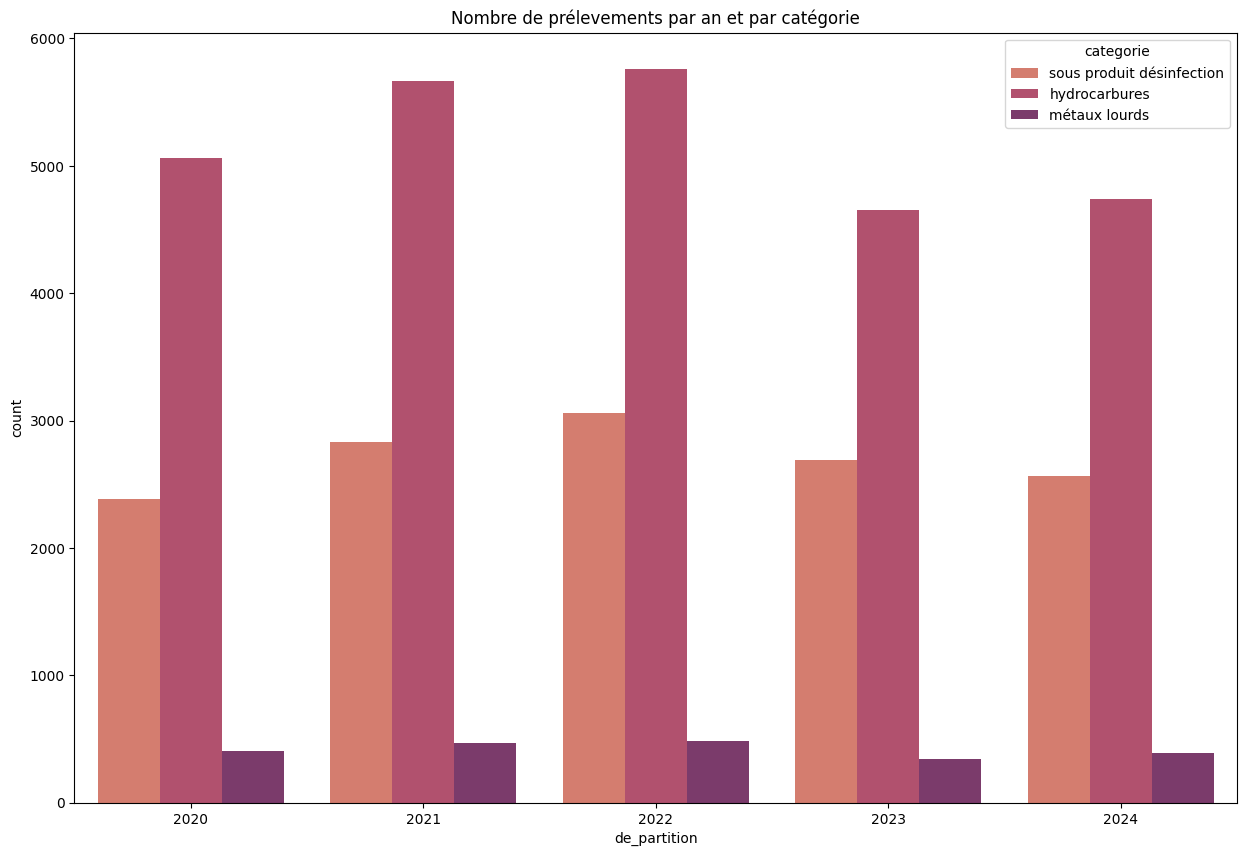

Evolution du nb de prélèvements par an pour la région Mayotte


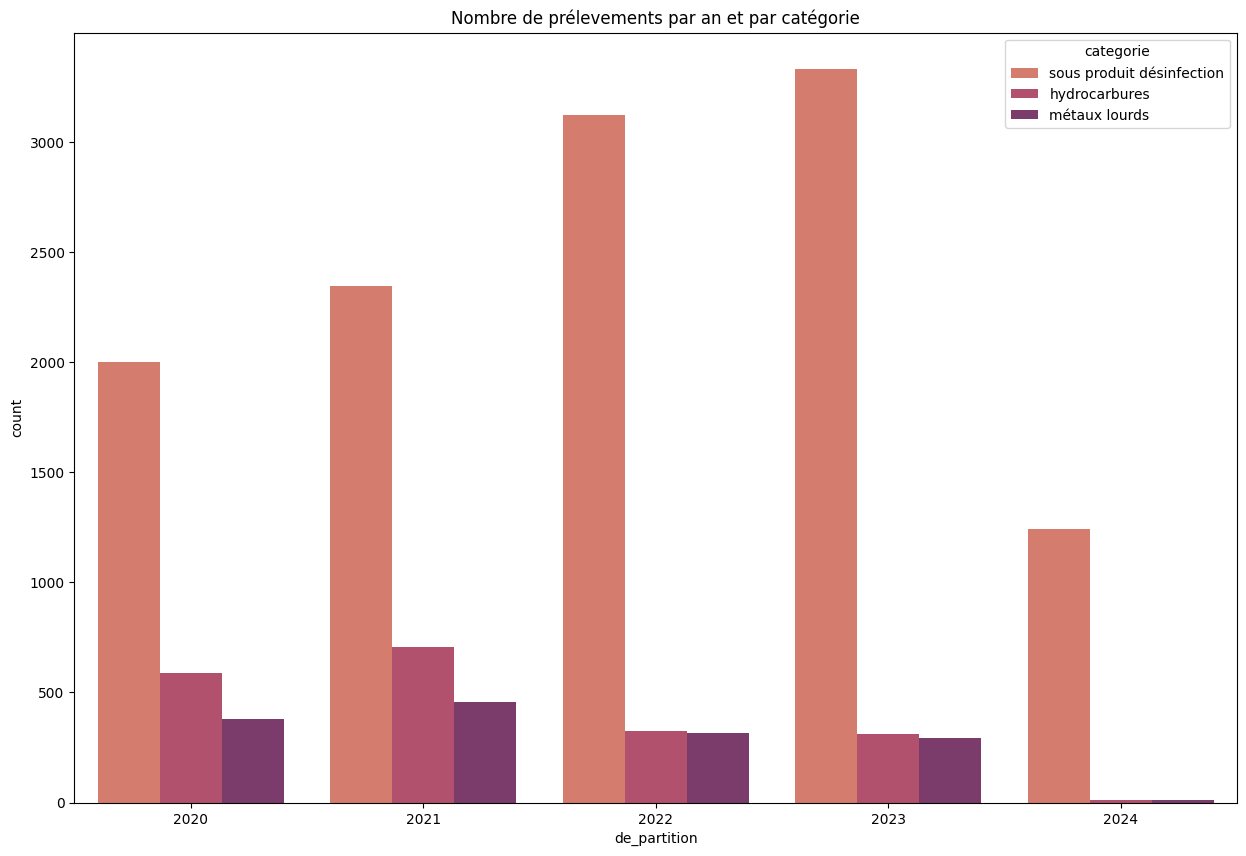

Evolution du nb de prélèvements par an pour la région Guyane


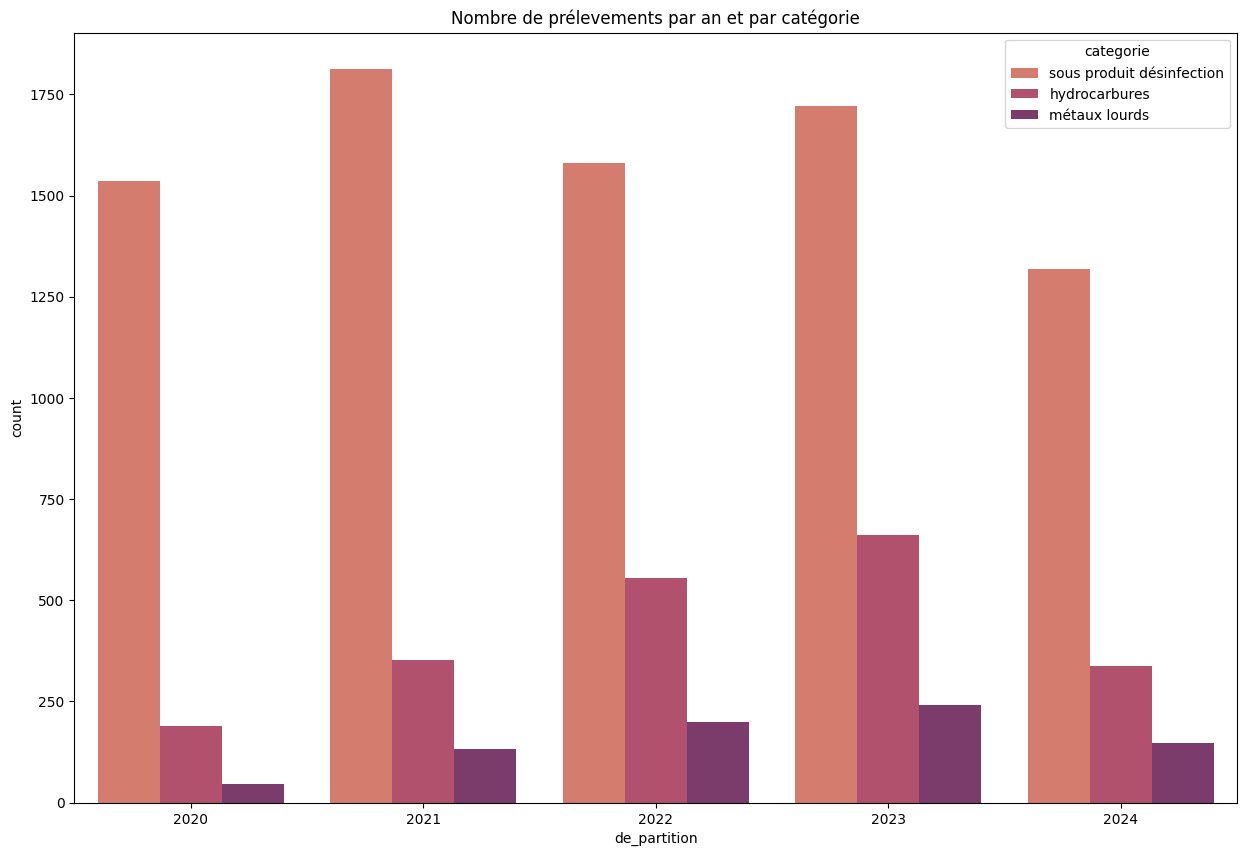

In [152]:
# Evolution nb de prélev par cat au cours des années sur une région donnée

for region in res_test_region['nom_region'].unique():
    print("Evolution du nb de prélèvements par an pour la région", region)
    plt.figure(figsize = [15, 10])
    sns.countplot(res_test_region[res_test_region['nom_region'] == region], x="de_partition", hue="categorie", palette = "flare", )
    plt.title('Nombre de prélevements par an et par catégorie')
    plt.show()



# III/ LIVRABLES PAULINE
***
Sur toute la France et par année: 
* Nb de prélèvements dans toute la France
* Régions concernées
* Fréquence de quantification de chaque paramètre
* Fréquence de non conformité...

## 1/ Pour chaque paramètre, quelle est la fréquence de quantification? 
***
Nombre de fois que le paramètre a été quantifié / nombre de fois que le paramètre est recherché dans l’année sur la France entière (quantification = ’une concentration dans l’eau a pu être mesurée).

In [616]:
year = 2020 # TO CHANGE 

print("Nombre de prélèvements par paramètre sur l'année", year, "sur la France entière.")
param_nb_an_2024 = res_test_region[res_test_region['de_partition'] == year].groupby(['categorie','libmajparametre']).size().reset_index(name='nb_prelevements_annuel').sort_values(by = 'nb_prelevements_annuel', ascending = False)



Nombre de prélèvements par paramètre sur l'année 2020 sur la France entière.


In [617]:
region_param_2024 = res_test_region[res_test_region['de_partition'] == year].groupby('libmajparametre')['nom_region'].unique().reset_index()

In [618]:
param_nb_2024_region = param_nb_an_2024.merge(region_param_2024, on = 'libmajparametre')

In [619]:
param_nb_2024_region.head(n = 2)

,categorie,libmajparametre,nb_prelevements_annuel,nom_region
0,sous produit désinfection,CHLORE LIBRE,253105,"[Auvergne-Rhône-Alpes, Provence-Alpes-Côte d'Azur, Hauts-de-France, Grand Est, Occitanie, Normandie, Nouvelle-Aquitaine, Centre-Val de Loire, Bourgogne-Franche-Comté, Bretagne, Corse, Pays de la Loire, Île-de-France, Guadeloupe, La Réunion, Martinique, Mayotte, Guyane]"
1,sous produit désinfection,CHLORE TOTAL,250888,"[Auvergne-Rhône-Alpes, Provence-Alpes-Côte d'Azur, Hauts-de-France, Grand Est, Occitanie, Normandie, Nouvelle-Aquitaine, Centre-Val de Loire, Bourgogne-Franche-Comté, Bretagne, Corse, Pays de la Loire, Île-de-France, Guadeloupe, La Réunion, Martinique, Mayotte, Guyane]"


In [620]:
# Création d'une nouvelle colonne qui indiquera si la valeur a bien été mesurée dans le prélèvement (avec une val numérique OU un seuil) 
res_test_region['quantif_presence'] = res_test_region['rqana'].astype(str).apply(lambda x: bool(re.search(r'\d', x)))
 
    

In [621]:
res_test_region['quantif_presence'].value_counts()

quantif_presence
True     7163477
False     248967
Name: count, dtype: int64

In [622]:
# Création d'une nouvelle colonne qui indiquera si la valeur une valeur numérique VS catégorielle (i.e, indiquée sous forme de seuil ou texte).
res_test_region['valeur_precise'] = res_test_region['rqana'].str.isalnum()
    

In [623]:
res_test_region['valeur_precise'].value_counts()

valeur_precise
False    7064328
True      325519
Name: count, dtype: int64

In [624]:
# Quantification du nb de cas 
quantif = res_test_region[ (res_test_region['de_partition'] == year) & res_test_region['quantif_presence']].groupby('libmajparametre').size().reset_index(name = 'nb_cas_quantif')
quantif_precise = res_test_region[ (res_test_region['de_partition'] == year) & res_test_region['valeur_precise']].groupby('libmajparametre').size().reset_index(name = 'nb_cas_valeur_precise')



In [625]:
# Merge avec notre df de base
param_nb_2024_region_quantif = param_nb_2024_region.merge(quantif, how = 'left', on = 'libmajparametre')

param_nb_2024_region_quantif_precis = param_nb_2024_region_quantif.merge(quantif_precise, how = 'left', on = 'libmajparametre')

In [626]:
param_nb_2024_region_quantif_precis.fillna(0, inplace = True)

In [627]:
# Création des colonnes de fréquences de quantification comme demandé, et suppression des colonnes inutiles. 
param_nb_2024_region_quantif_precis['prct_quantif'] = 100*(param_nb_2024_region_quantif_precis['nb_cas_quantif'] / param_nb_2024_region_quantif_precis['nb_prelevements_annuel'])
param_nb_2024_region_quantif_precis['prct_quantif_precise'] = 100*(param_nb_2024_region_quantif_precis['nb_cas_valeur_precise'] / param_nb_2024_region_quantif_precis['nb_prelevements_annuel'])

param_nb_2024_region_quantif_precis.drop(columns = ['nb_cas_quantif', 'nb_cas_valeur_precise'], inplace = True)


In [628]:
param_nb_2024_region_quantif_precis.head()

,categorie,libmajparametre,nb_prelevements_annuel,nom_region,prct_quantif,prct_quantif_precise
0,sous produit désinfection,CHLORE LIBRE,253105,"[Auvergne-Rhône-Alpes, Provence-Alpes-Côte d'Azur, Hauts-de-France, Grand Est, Occitanie, Normandie, Nouvelle-Aquitaine, Centre-Val de Loire, Bourgogne-Franche-Comté, Bretagne, Corse, Pays de la Loire, Île-de-France, Guadeloupe, La Réunion, Martinique, Mayotte, Guyane]",98.702515,0.329508
1,sous produit désinfection,CHLORE TOTAL,250888,"[Auvergne-Rhône-Alpes, Provence-Alpes-Côte d'Azur, Hauts-de-France, Grand Est, Occitanie, Normandie, Nouvelle-Aquitaine, Centre-Val de Loire, Bourgogne-Franche-Comté, Bretagne, Corse, Pays de la Loire, Île-de-France, Guadeloupe, La Réunion, Martinique, Mayotte, Guyane]",99.031839,0.303323
2,sous produit désinfection,CHLORURES,117764,"[Auvergne-Rhône-Alpes, Provence-Alpes-Côte d'Azur, Hauts-de-France, Grand Est, Occitanie, Normandie, Nouvelle-Aquitaine, Centre-Val de Loire, Bourgogne-Franche-Comté, Bretagne, Corse, Pays de la Loire, Île-de-France, Guadeloupe, La Réunion, Martinique, Mayotte, Guyane]",99.959241,16.212085
3,sous produit désinfection,BIOXYDE DE CHLORE MG/L CLO2,31187,"[Auvergne-Rhône-Alpes, Grand Est, Hauts-de-France, Occitanie, Centre-Val de Loire, Nouvelle-Aquitaine, Bourgogne-Franche-Comté, Normandie, Bretagne, Pays de la Loire, Île-de-France, Provence-Alpes-Côte d'Azur, Guadeloupe]",17.882451,0.307821
4,sous produit désinfection,CHLORODIBROMOMÉTHANE,28822,"[Auvergne-Rhône-Alpes, Provence-Alpes-Côte d'Azur, Hauts-de-France, Grand Est, Occitanie, Normandie, Nouvelle-Aquitaine, Centre-Val de Loire, Bourgogne-Franche-Comté, Bretagne, Corse, Pays de la Loire, Île-de-France, Guadeloupe, La Réunion, Martinique, Mayotte, Guyane]",99.875095,6.512386


## 2/ Lesquels sont associés dans la base de données à une limite de qualité et quelle est la valeur de la limite de qualité indiquée?

In [629]:
limites = res_test_region[res_test_region['de_partition'] == year].groupby('libmajparametre')['limitequal'].value_counts().reset_index()

In [630]:
param_nb_2020_region_quantif_precis_limite = param_nb_2024_region_quantif_precis.merge(limites[['libmajparametre', 'limitequal']], on = 'libmajparametre')



In [631]:
param_nb_2020_region_quantif_precis_limite.head(n=2)

,categorie,libmajparametre,nb_prelevements_annuel,nom_region,prct_quantif,prct_quantif_precise,limitequal
0,sous produit désinfection,CHLORODIBROMOMÉTHANE,28822,"[Auvergne-Rhône-Alpes, Provence-Alpes-Côte d'Azur, Hauts-de-France, Grand Est, Occitanie, Normandie, Nouvelle-Aquitaine, Centre-Val de Loire, Bourgogne-Franche-Comté, Bretagne, Corse, Pays de la Loire, Île-de-France, Guadeloupe, La Réunion, Martinique, Mayotte, Guyane]",99.875095,6.512386,<=100 µg/L
1,sous produit désinfection,CHLOROFORME,28822,"[Auvergne-Rhône-Alpes, Provence-Alpes-Côte d'Azur, Hauts-de-France, Grand Est, Occitanie, Normandie, Nouvelle-Aquitaine, Centre-Val de Loire, Bourgogne-Franche-Comté, Bretagne, Corse, Pays de la Loire, Île-de-France, Guadeloupe, La Réunion, Martinique, Mayotte, Guyane]",99.875095,9.798071,<=100 µg/L


In [632]:
param_nb_2021_region_quantif_precis_limite['limitequal'].unique()

array(['<=100 µg/L', '<=10 µg/L', '<=3 µg/L', '<=0.01 µg/L', '<=0.1 µg/L',
       '<=20 µg/L', '<=5 µg/L', '<=50 µg/L', '<=1 µg/L', '<=2 mg/L',
       '<=0.25 mg/L', '<=6 µg/L', '<=250 µg/L', '<=50.0 µg/L'],
      dtype=object)

## 3/ Pour ceux avec une limite de qualité, quelle est la fréquence de dépassement de cette limite par an? 
(nombre de fois qu’il y a un dépassement / nombre de fois que le paramètre est recherché dans l’année sur la France entière)


### /!\ Exploitabilité de valtraduite: Vérif que valtraduite ne soit pas à 0 alors que rqana > seuil 

In [633]:
# Cleaning des valeurs pour ensuite pouvoir les comparer. 
res_test_region['rqana'].replace(",", ".", regex = True, inplace = True)

res_test_region['limitequal'].replace(",", ".", regex = True, inplace = True)

In [634]:
# On extrait uniquement les chiffres et on exclue tous les autres caractères, pour vraiment avoir des valeurs numériques. 
res_test_region['num_rqana'] = res_test_region['rqana'].astype(str).apply(lambda x: re.sub("[^\d\.]", "", x))

In [635]:
res_test_region['num_limite'] = res_test_region['limitequal'].astype(str).apply(lambda x: re.sub("[^\d\.]", "", x))

In [636]:
res_test_region['limitequal'].unique()

array(['<=10 µg/L', '<=1 µg/L', '<=100 µg/L', None, '<=20 µg/L',
       '<=3 µg/L', '<=0.1 µg/L', '<=5 µg/L', '<=50 µg/L', '<=2 mg/L',
       '<=0.01 µg/L', '<=6 µg/L', '<=50.0 µg/L', '<=250 µg/L',
       '<=0.25 mg/L', '<=0.7 mg/L', '<=700 µg/L',
       '<=5 NG/(KG POIDS CORPOREL/J)', '<=30 µg/L', '<=60 µg/L'],
      dtype=object)

In [637]:
res_test_region['num_limite'].unique()

array(['10', '1', '100', '', '20', '3', '0.1', '5', '50', '2', '0.01',
       '6', '50.0', '250', '0.25', '0.7', '700', '30', '60'], dtype=object)

In [638]:
res_test_region['limitequal'].value_counts(dropna = False)
# /!\ 4768215 lignes sans valeurs limite... Donc colonne pas complète même si on a des valeurs relevées, on ne pourra pas comparer aux seuils...

limitequal
None                            4768215
<=100 µg/L                       686261
<=10 µg/L                        618878
<=0.1 µg/L                       596997
<=1 µg/L                         168238
<=20 µg/L                        144824
<=3 µg/L                          91880
<=0.01 µg/L                       87748
<=5 µg/L                          85197
<=50 µg/L                         85034
<=2 mg/L                          53904
<=0.25 mg/L                       13984
<=6 µg/L                           4731
<=0.7 mg/L                         3086
<=5 NG/(KG POIDS CORPOREL/J)       1567
<=250 µg/L                          807
<=700 µg/L                          791
<=30 µg/L                           216
<=50.0 µg/L                          77
<=60 µg/L                             9
Name: count, dtype: int64

In [639]:
res_test_region['num_rqana'] = res_test_region['num_rqana'].replace('', np.nan, regex=True)
res_test_region['num_limite'] = res_test_region['num_limite'].replace('', np.nan, regex=True)

# Attention aux valeurs <SANS SEUIL qui vont passer à la trappe, cela dit cette mention est discutable
# car pas moyen de connaître la valeur mesurée...

In [640]:
res_test_region['num_rqana'] = res_test_region['num_rqana'].replace(',','.')

In [641]:
quant = res_test_region[(res_test_region['de_partition'] == year) & (res_test_region['qualitparam'] == 'N') & (res_test_region['quantif_presence'])]


In [642]:
quant['num_rqana'] = quant['num_rqana'].astype('float64')
quant['num_limite'] = quant['num_limite'].astype('float64')

In [643]:
len(quant)

1528986

In [644]:
# CAS PEU FIABLES: 
# Cas où valtraduite mentionne "0" alors que la valeur seuil > limite ce qui ne permet pas d'affirmer à 100% que le taux est conforme (voir exemples ci-dessous). 
quant[(quant['valtraduite'] == 0) & (quant['num_rqana'].astype(float) > quant['num_limite'].astype(float))]

# /!\6830/1372422 cas sur 2024 soit 0.5% où valtraduite n'est pas fiable...
#.   6536 / 1406628 su 2023
# incertitude sur ces valeurs. 


,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,de_partition,de_ingestion_date,de_dataset_datetime,categorie,dep,code_departement,nom_departement,nom_region,quantif_presence,valeur_precise,num_rqana,num_limite
272,004,00400124255,HEXBU,1652,HEXACHLOROBUTADIÈNE (PESTICIDE),Hexachlorobutadiène (pesticide),None,N,L,<0.50,µg/L,133,<=0.1 µg/L,None,0.0,87-68-3,00400124319,2020,2025-02-14,20230811-150005,hydrocarbures,04,04,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur,True,False,0.5,0.1
303,004,00400124256,HEXBU,1652,HEXACHLOROBUTADIÈNE (PESTICIDE),Hexachlorobutadiène (pesticide),None,N,L,<0.50,µg/L,133,<=0.1 µg/L,None,0.0,87-68-3,00400124320,2020,2025-02-14,20230811-150005,hydrocarbures,04,04,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur,True,False,0.5,0.1
334,004,00400124257,HEXBU,1652,HEXACHLOROBUTADIÈNE (PESTICIDE),Hexachlorobutadiène (pesticide),None,N,L,<0.50,µg/L,133,<=0.1 µg/L,None,0.0,87-68-3,00400124321,2020,2025-02-14,20230811-150005,hydrocarbures,04,04,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur,True,False,0.5,0.1
557,001,00100119509,12DCP,1655,"DICHLOROPROPANE-1,2","Dichloropropane-1,2",None,N,L,<0.50,µg/L,133,<=0.1 µg/L,None,0.0,78-87-5,00100126245,2020,2025-02-14,20230811-150005,hydrocarbures,01,01,Ain,Auvergne-Rhône-Alpes,True,False,0.5,0.1
577,001,00100119509,HEXBU,1652,HEXACHLOROBUTADIÈNE (PESTICIDE),Hexachlorobutadiène (pesticide),None,N,L,<0.50,µg/L,133,<=0.1 µg/L,None,0.0,87-68-3,00100126245,2020,2025-02-14,20230811-150005,hydrocarbures,01,01,Ain,Auvergne-Rhône-Alpes,True,False,0.5,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924445,032,03200084418,12DCP,1655,"DICHLOROPROPANE-1,2","Dichloropropane-1,2",None,N,L,<1,µg/L,133,<=0.1 µg/L,None,0.0,78-87-5,03200087343,2020,2025-02-14,20230811-150005,hydrocarbures,32,32,Gers,Occitanie,True,False,1.0,0.1
1924446,032,03200084419,12DCP,1655,"DICHLOROPROPANE-1,2","Dichloropropane-1,2",None,N,L,<1,µg/L,133,<=0.1 µg/L,None,0.0,78-87-5,03200087344,2020,2025-02-14,20230811-150005,hydrocarbures,32,32,Gers,Occitanie,True,False,1.0,0.1
3837845,046,04600082618,12DCP,1655,"DICHLOROPROPANE-1,2","Dichloropropane-1,2",None,N,L,<1,µg/L,133,<=0.1 µg/L,None,0.0,78-87-5,04600083198,2020,2025-02-14,20230811-150005,hydrocarbures,46,46,Lot,Occitanie,True,False,1.0,0.1
3837861,046,04600082621,12DCP,1655,"DICHLOROPROPANE-1,2","Dichloropropane-1,2",None,N,L,<1,µg/L,133,<=0.1 µg/L,None,0.0,78-87-5,04600083201,2020,2025-02-14,20230811-150005,hydrocarbures,46,46,Lot,Occitanie,True,False,1.0,0.1


### Proportion de relevés non conformes sur le nombre de relevés total 

In [645]:
quant['non_conforme'] = quant['valtraduite'] > quant['num_limite']

In [646]:
non_conf_quant = quant[quant['non_conforme']]

In [647]:
non_conf_quant_count = non_conf_quant.groupby('libmajparametre').size().reset_index(name = 'nb_cas_nc')

In [648]:
param_nb_2020_region_quantif_precis_limite_nc = param_nb_2020_region_quantif_precis_limite.merge(non_conf_quant_count, how = 'left', on = 'libmajparametre')


In [649]:
param_nb_2020_region_quantif_precis_limite_nc['prct_non_conforme'] = 100*(param_nb_2020_region_quantif_precis_limite_nc['nb_cas_nc'] / param_nb_2020_region_quantif_precis_limite_nc['nb_prelevements_annuel'])



In [650]:
param_nb_2020_region_quantif_precis_limite_nc.drop(columns = 'nb_cas_nc', inplace = True)

## EXPORT DES DONNÉES

In [651]:
final_2020 = param_nb_2020_region_quantif_precis_limite_nc.sort_values(by = 'categorie')

In [652]:
final_2020.to_csv('2020_quantif_conform_param', sep='\t', encoding='utf-8', index=False, header=True)